# 📌 Situação Problema
- Este código busca prever a temperatura máxima e mínima para o próximo dia (Next_Tmax e Next_Tmin), com base em variáveis climáticas históricas.


---

# Dataset

About Dataset
Temperature Forecast Project using ML
Problem Statement:
Data Set Information: This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model 
operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. 
The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. 
There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

Attribute Information: For more information, read [Cho et al, 2020].

| #  | Nome da Variável      | Descrição                                                                 | Faixa de Valores          |
|----|------------------------|---------------------------------------------------------------------------|----------------------------|
| 1  | station                | Número da estação meteorológica usada                                     | 1 a 25                     |
| 2  | Date                   | Data atual no formato yyyy-mm-dd                                          | 2013-06-30 a 2017-08-30    |
| 3  | Present_Tmax          | Temperatura máxima entre 0h e 21h no dia atual (°C)                        | 20 a 37.6                  |
| 4  | Present_Tmin          | Temperatura mínima entre 0h e 21h no dia atual (°C)                        | 11.3 a 29.9                |
| 5  | LDAPS_RHmin           | Previsão de umidade relativa mínima para o dia seguinte (%)               | 19.8 a 98.5                |
| 6  | LDAPS_RHmax           | Previsão de umidade relativa máxima para o dia seguinte (%)               | 58.9 a 100                 |
| 7  | LDAPS_Tmax_lapse      | Previsão da temperatura máxima do dia seguinte com taxa de variação (°C)  | 17.6 a 38.5                |
| 8  | LDAPS_Tmin_lapse      | Previsão da temperatura mínima do dia seguinte com taxa de variação (°C)  | 14.3 a 29.6                |
| 9  | LDAPS_WS              | Previsão da velocidade média do vento no dia seguinte (m/s)               | 2.9 a 21.9                 |
| 10 | LDAPS_LH              | Previsão do fluxo médio de calor latente (W/m²)                           | -13.6 a 213.4              |
| 11 | LDAPS_CC1             | Cobertura média de nuvens (0-5h) no dia seguinte (%)                      | 0 a 0.97                   |
| 12 | LDAPS_CC2             | Cobertura média de nuvens (6-11h) no dia seguinte (%)                     | 0 a 0.97                   |
| 13 | LDAPS_CC3             | Cobertura média de nuvens (12-17h) no dia seguinte (%)                    | 0 a 0.98                   |
| 14 | LDAPS_CC4             | Cobertura média de nuvens (18-23h) no dia seguinte (%)                    | 0 a 0.97                   |
| 15 | LDAPS_PPT1            | Precipitação média (0-5h) no dia seguinte (%)                              | 0 a 23.7                   |
| 16 | LDAPS_PPT2            | Precipitação média (6-11h) no dia seguinte (%)                             | 0 a 21.6                   |
| 17 | LDAPS_PPT3            | Precipitação média (12-17h) no dia seguinte (%)                            | 0 a 15.8                   |
| 18 | LDAPS_PPT4            | Precipitação média (18-23h) no dia seguinte (%)                            | 0 a 16.7                   |
| 19 | lat                   | Latitude (°)                                                              | 37.456 a 37.645            |
| 20 | lon                   | Longitude (°)                                                             | 126.826 a 127.135          |
| 21 | DEM                   | Elevação do terreno (m)                                                   | 12.4 a 212.3               |
| 22 | Slope                 | Inclinação do terreno (°)                                                 | 0.1 a 5.2                  |
| 23 | Solar radiation       | Radiação solar diária incidente (Wh/m²)                                   | 4329.5 a 5992.9            |
| 24 | Next_Tmax             | Temperatura máxima prevista para o dia seguinte (°C)                      | 17.4 a 38.9                |
| 25 | Next_Tmin             | Temperatura mínima prevista para o dia seguinte (°C)                      | 11.3 a 29.8                |


Please note that there are two target variables here:
1) Next_Tmax: Next day maximum temperature
2) Next_Tmin: Next day minimum temperature


# Importando Bibliotecas

In [15]:
# 📦 Imports e Configurações Iniciais
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


from time import time
from tqdm import tqdm
import lightgbm as lgbm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree

In [16]:
# Define uma função lambda chamada create_numeric_feature.
# Essa função recebe um argumento (input_data0) e retorna uma cópia exata do objeto recebido.
# Isso é útil para evitar modificações acidentais nos dados originais,
# criando uma nova instância independente que pode ser manipulada livremente.
create_numeric_feature = lambda input_data0: input_data0.copy()

# Carga e Avaliação e Tratamento dos Dados

In [17]:
# Carregamento e Preprocessamento dos Dados
# Carrega base CSV, preenche valores ausentes com 0 e remove colunas irrelevantes
data0 = pd.read_csv("temp.csv")

In [18]:
# Exibe as primeiras 5 linhas do DataFrame data0
data0.head()

station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
0      1.0  30-06-2013          28.7          21.4    58.255688    91.116364   
1      2.0  30-06-2013          31.9          21.6    52.263397    90.604721   
2      3.0  30-06-2013          31.6          23.3    48.690479    83.973587   
3      4.0  30-06-2013          32.0          23.4    58.239788    96.483688   
4      5.0  30-06-2013          31.4          21.9    56.174095    90.155128   

   LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS    LDAPS_LH  ...  LDAPS_PPT2  \
0         28.074101         23.006936  6.818887   69.451805  ...         0.0   
1         29.850689         24.035009  5.691890   51.937448  ...         0.0   
2         30.091292         24.565633  6.138224   20.573050  ...         0.0   
3         29.704629         23.326177  5.650050   65.727144  ...         0.0   
4         29.113934         23.486480  5.735004  107.965535  ...         0.0   

   LDAPS_PPT3  LDAPS_PPT4      lat      lon       DEM   Slope  \
0         0.0         0.0  37.6046  126.991  212.3350  2.7850   
1         0.0         0.0  37.6046  127.032   44.7624  0.5141   
2         0.0         0.0  37.5776  127.058   33.3068  0.2661   
3         0.0         0.0  37.6450  127.022   45.7160  2.5348   
4         0.0         0.0  37.5507  127.135   35.0380  0.5055   

   Solar radiation  Next_Tmax  Next_Tmin  
0      5992.895996       29.1       21.2  
1      5869.312500       30.5       22.5  
2      5863.555664       31.1       23.9  
3      5856.964844       31.7       24.3  
4      5859.552246       31.2       22.5  

[5 rows x 25 columns]

In [19]:
# Formato do conjunto de dados
# O conjunto de dados possui um total de 7752 registros e 25 colunas, incluindo 2 colunas-alvo
data0.shape

(7752, 25)

In [20]:
# Lista com os nomes das colunas
data0.columns

Index(['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin',
       'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon',
       'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

In [21]:
# Pré-processamento
# Temos 24 variáveis do tipo float64 e 1 variável do tipo objeto. 
# As variáveis-alvo "Next_Tmax" e "Next_Tmin" também são do tipo float64
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


In [22]:
# Vamos traçar um mapa de calor para identificar se há valores nulos.
# Temos muitos valores ausentes em todos os recursos, incluindo as duas colunas de destino.
# Os únicos recursos que não apresentam valores ausentes são "lat", "lon", "DEM", "Slope" e "Solar radiation".
data0.isnull().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_29332\2501597873.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data0.isnull().sum()[lambda x: x > 0].index, y=data0.isnull().sum()[lambda x: x > 0].values, palette="viridis"); plt.xticks(rotation=90); plt.ylabel("Valores nulos"); plt.xlabel("Colunas"); plt.title("Valores nulos por coluna"); plt.tight_layout()


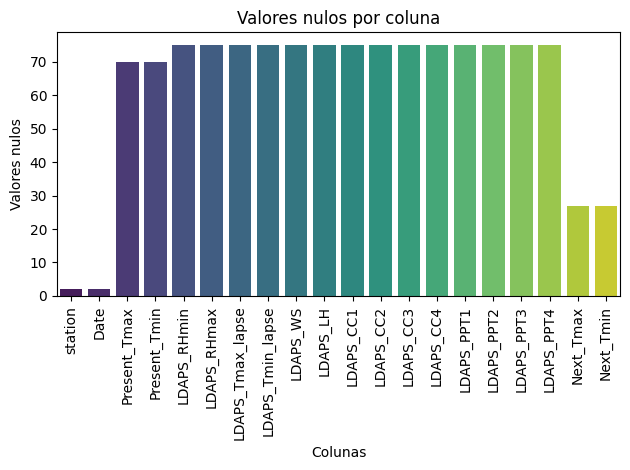

In [23]:
# Podemos observar o mesmo acima em formato gráfico
sns.barplot(x=data0.isnull().sum()[lambda x: x > 0].index, y=data0.isnull().sum()[lambda x: x > 0].values, palette="viridis"); plt.xticks(rotation=90); plt.ylabel("Valores nulos"); plt.xlabel("Colunas"); plt.title("Valores nulos por coluna"); plt.tight_layout()

In [24]:
# Observe as colunas individuais. Como temos 27 valores ausentes nas colunas alvo "Next_Tmax" e "Next_Tmin" de um total de 7750 registros, vamos descartar toda a linha correspondente a esses valores ausentes.
# Apagou os nulos das colunas destino
data0.dropna(axis=0, how='any', subset=['Next_Tmax', 'Next_Tmin'], inplace=True)

In [25]:
# Agora temos 7725 registros, pois 27 linhas foram descartadas, conforme mencionado anteriormente.
data0.shape

(7725, 25)

In [26]:
# Podemos ver a partir do abaixo que os valores nulos não existem mais nas colunas de destino
data0.isnull().sum()

station              2
Date                 2
Present_Tmax        60
Present_Tmin        60
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax            0
Next_Tmin            0
dtype: int64

In [27]:
# Tratando os valores Nan. Como todos esses recursos são dados contínuos, preenchi os valores ausentes com o valor da "média".
# Para isso usaremos a média 

data0["Present_Tmax"] = data0["Present_Tmax"].fillna(data0["Present_Tmax"].mean())
data0["Present_Tmin"] = data0["Present_Tmin"].fillna(data0["Present_Tmin"].mean())
data0["LDAPS_RHmin"] = data0["LDAPS_RHmin"].fillna(data0["LDAPS_RHmin"].mean())
data0["LDAPS_RHmax"] = data0["LDAPS_RHmax"].fillna(data0["LDAPS_RHmax"].mean())
data0["LDAPS_Tmax_lapse"] = data0["LDAPS_Tmax_lapse"].fillna(data0["LDAPS_Tmax_lapse"].mean())
data0["LDAPS_Tmin_lapse"] = data0["LDAPS_Tmin_lapse"].fillna(data0["LDAPS_Tmin_lapse"].mean())
data0["LDAPS_WS"] = data0["LDAPS_WS"].fillna(data0["LDAPS_WS"].mean())
data0["LDAPS_LH"] = data0["LDAPS_LH"].fillna(data0["LDAPS_LH"].mean())
data0["LDAPS_CC1"] = data0["LDAPS_CC1"].fillna(data0["LDAPS_CC1"].mean())
data0["LDAPS_CC2"] = data0["LDAPS_CC2"].fillna(data0["LDAPS_CC2"].mean())
data0["LDAPS_CC3"] = data0["LDAPS_CC3"].fillna(data0["LDAPS_CC3"].mean())
data0["LDAPS_CC4"] = data0["LDAPS_CC4"].fillna(data0["LDAPS_CC4"].mean())
data0["LDAPS_PPT1"] = data0["LDAPS_PPT1"].fillna(data0["LDAPS_PPT1"].mean())
data0["LDAPS_PPT2"] = data0["LDAPS_PPT2"].fillna(data0["LDAPS_PPT2"].mean())
data0["LDAPS_PPT3"] = data0["LDAPS_PPT3"].fillna(data0["LDAPS_PPT3"].mean())
data0["LDAPS_PPT4"] = data0["LDAPS_PPT4"].fillna(data0["LDAPS_PPT4"].mean())

In [28]:
# Evitei deliberadamente as variáveis "station" e "Date", pois "station" representa uma entidade entre 25 localidades e o preenchimento de valores ausentes poderia alterar os resultados.
# A variável "Date" está em base diária e a temperatura é consistente, portanto preencher valores nessa coluna também poderia distorcer os resultados.
# Essas colunas também serão removidas, pois obtive resultados melhores sem utilizá-las.
data0.isnull().sum()

station             2
Date                2
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

In [29]:
# Vamos agora observar as estatísticas do conjunto de dados
# Todos os valores foram contabilizados e não há valores ausentes
# A diferença entre a média e o desvio padrão também parece adequada.
# No entanto, verificaremos a existência de assimetria (skewness) nas etapas seguintes
data0.describe()

station  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
count  7723.000000   7725.000000   7725.000000  7725.000000  7725.000000   
mean     13.008157     29.769563     23.224631    56.741402    88.369140   
std       7.214034      2.959205      2.405561    14.583630     7.164028   
min       1.000000     20.000000     11.300000    19.794666    58.936283   
25%       7.000000     27.800000     21.700000    46.045017    84.291199   
50%      13.000000     29.900000     23.400000    55.266701    89.699196   
75%      19.000000     32.000000     24.900000    66.996681    93.704353   
max      25.000000     37.600000     29.900000    98.524734   100.000153   

       LDAPS_Tmax_lapse  LDAPS_Tmin_lapse     LDAPS_WS     LDAPS_LH  \
count       7725.000000       7725.000000  7725.000000  7725.000000   
mean          29.616253         23.511807     7.096739    62.468599   
std            2.932271          2.333987     2.171835    33.556339   
min           17.624954         14.272646     2.882580   -13.603212   
25%           27.696185         22.114277     5.686496    37.452979   
50%           29.664030         23.733589     6.564141    57.299645   
75%           31.687106         25.135301     7.996899    83.897461   
max           38.542255         29.619342    21.857621   213.414006   

         LDAPS_CC1  ...   LDAPS_PPT2   LDAPS_PPT3   LDAPS_PPT4          lat  \
count  7725.000000  ...  7725.000000  7725.000000  7725.000000  7725.000000   
mean      0.368482  ...     0.484298     0.277121     0.269440    37.544755   
std       0.261052  ...     1.752597     1.152456     1.199982     0.050386   
min       0.000000  ...     0.000000     0.000000     0.000000    37.456200   
25%       0.148229  ...     0.000000     0.000000     0.000000    37.510200   
50%       0.319678  ...     0.000000     0.000000     0.000000    37.550700   
75%       0.571547  ...     0.024035     0.009649     0.000703    37.577600   
max       0.967277  ...    21.621661    15.841235    16.655469    37.645000   

               lon          DEM        Slope  Solar radiation    Next_Tmax  \
count  7725.000000  7725.000000  7725.000000      7725.000000  7725.000000   
mean    126.991370    61.926856     1.258725      5342.066031    30.274887   
std       0.079347    54.331701     1.371331       429.235277     3.128010   
min     126.826000    12.370000     0.098475      4329.520508    17.400000   
25%     126.937000    28.700000     0.271300      4999.018555    28.200000   
50%     126.995000    45.716000     0.618000      5437.534180    30.500000   
75%     127.042000    59.832400     1.767800      5728.624512    32.600000   
max     127.135000   212.335000     5.178230      5992.895996    38.900000   

         Next_Tmin  
count  7725.000000  
mean     22.932220  
std       2.487613  
min      11.300000  
25%      21.300000  
50%      23.100000  
75%      24.600000  
max      29.800000  

[8 rows x 24 columns]

In [30]:
len(data0["Next_Tmax"])

7725

In [31]:
len(data0["Next_Tmin"])

7725

In [32]:
# Vamos dividir a coluna "Date" em "Month" (Mês) e "Year" (Ano), pois as temperaturas parecem variar de acordo com essas informações
data0['Year'] = pd.DatetimeIndex(data0['Date']).year
data0['Month'] = pd.DatetimeIndex(data0['Date']).month

In [33]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7725 entries, 0 to 7751
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7723 non-null   float64
 1   Date              7723 non-null   object 
 2   Present_Tmax      7725 non-null   float64
 3   Present_Tmin      7725 non-null   float64
 4   LDAPS_RHmin       7725 non-null   float64
 5   LDAPS_RHmax       7725 non-null   float64
 6   LDAPS_Tmax_lapse  7725 non-null   float64
 7   LDAPS_Tmin_lapse  7725 non-null   float64
 8   LDAPS_WS          7725 non-null   float64
 9   LDAPS_LH          7725 non-null   float64
 10  LDAPS_CC1         7725 non-null   float64
 11  LDAPS_CC2         7725 non-null   float64
 12  LDAPS_CC3         7725 non-null   float64
 13  LDAPS_CC4         7725 non-null   float64
 14  LDAPS_PPT1        7725 non-null   float64
 15  LDAPS_PPT2        7725 non-null   float64
 16  LDAPS_PPT3        7725 non-null   float64
 17  

# Geraçao de Análise Exploratória dos dados com o Pandas Profiling

In [34]:
# Importa a classe ProfileReport da biblioteca pandas_profiling, usada para gerar relatórios exploratórios automáticos de um DataFrame.
# from pandas_profiling import ProfileReport

# Cria um relatório de análise exploratória de dados com base no DataFrame data0, atribuindo o título "My Data Profile Report".
# O relatório inclui estatísticas descritivas, distribuição de variáveis, detecção de valores ausentes, correlações, entre outros.
# profile = ProfileReport(data0, title="Relatório de Análise temperatura Korea")

In [35]:
# Execute esta linha se não conseguir visualizar o relatório no Jupyter Notebook.
# Baixe o arquivo HTML e visualize-o em uma janela separada


#profile.to_file("korea_temp_report.html")

### Outras análises visuais dos Dados

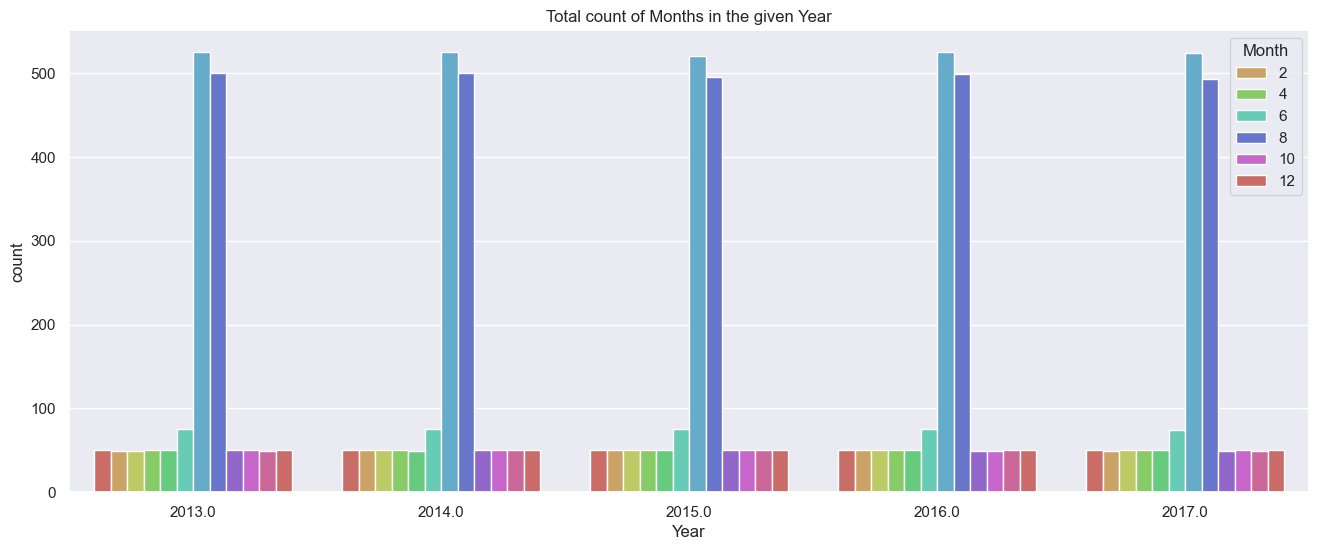

In [36]:
# Vamos gerar alguns gráficos para melhor compreensão
# A partir do gráfico abaixo, podemos observar que o conjunto de dados contém informações dos anos de 2013 a 2017, e que há mais dados registrados para os meses de "julho" e "agosto" 
# em comparação com os demais meses

plt.figure(figsize=(16, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Year", data=data0, palette="hls", hue="Month").set(title='Total count of Months in the given Year')

C:\Users\User\AppData\Local\Temp\ipykernel_29332\3347482780.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Year", y="Present_Tmax", data=data0, palette="Set3")


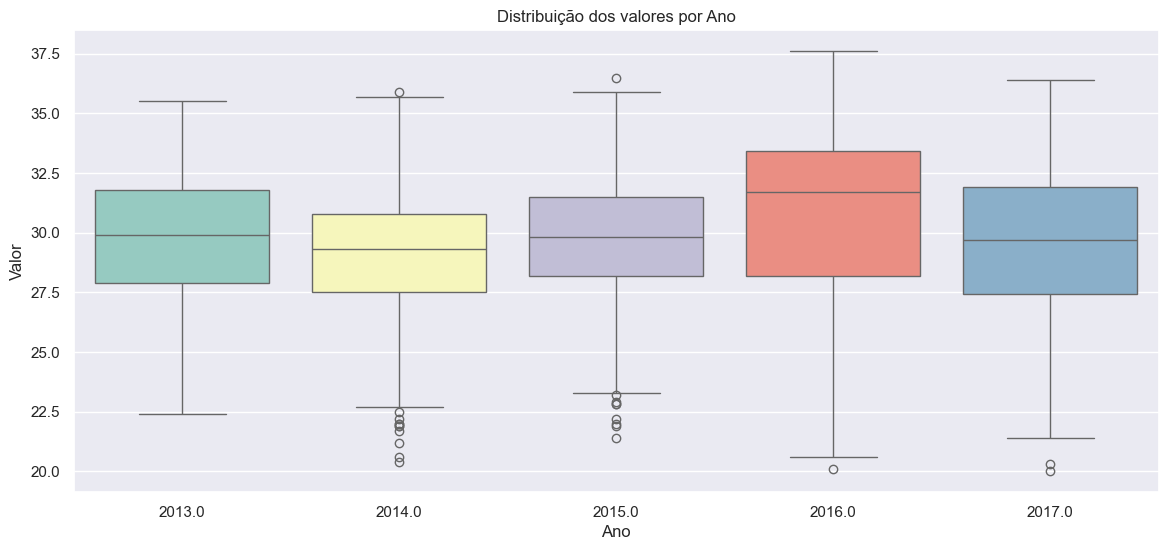

In [37]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="Year", y="Present_Tmax", data=data0, palette="Set3")
plt.title("Distribuição dos valores por Ano")
plt.xlabel("Ano")
plt.ylabel("Valor")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_29332\1955473142.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Month", y="Present_Tmax", data=data0, palette="Set2")


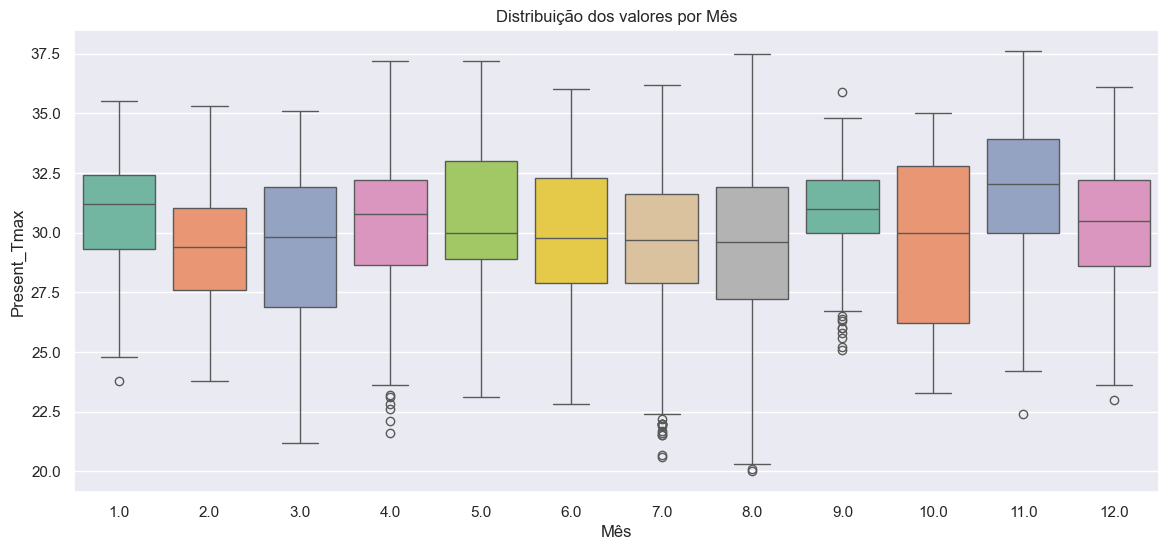

In [38]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="Month", y="Present_Tmax", data=data0, palette="Set2")
plt.title("Distribuição dos valores por Mês")
plt.xlabel("Mês")
plt.ylabel("Present_Tmax")
plt.show()


In [39]:
# Conforme mencionado no início, removemos as colunas "station" e "Date"
data0.drop(columns=["station","Date"], inplace=True)

In [40]:
data0.shape

(7725, 25)

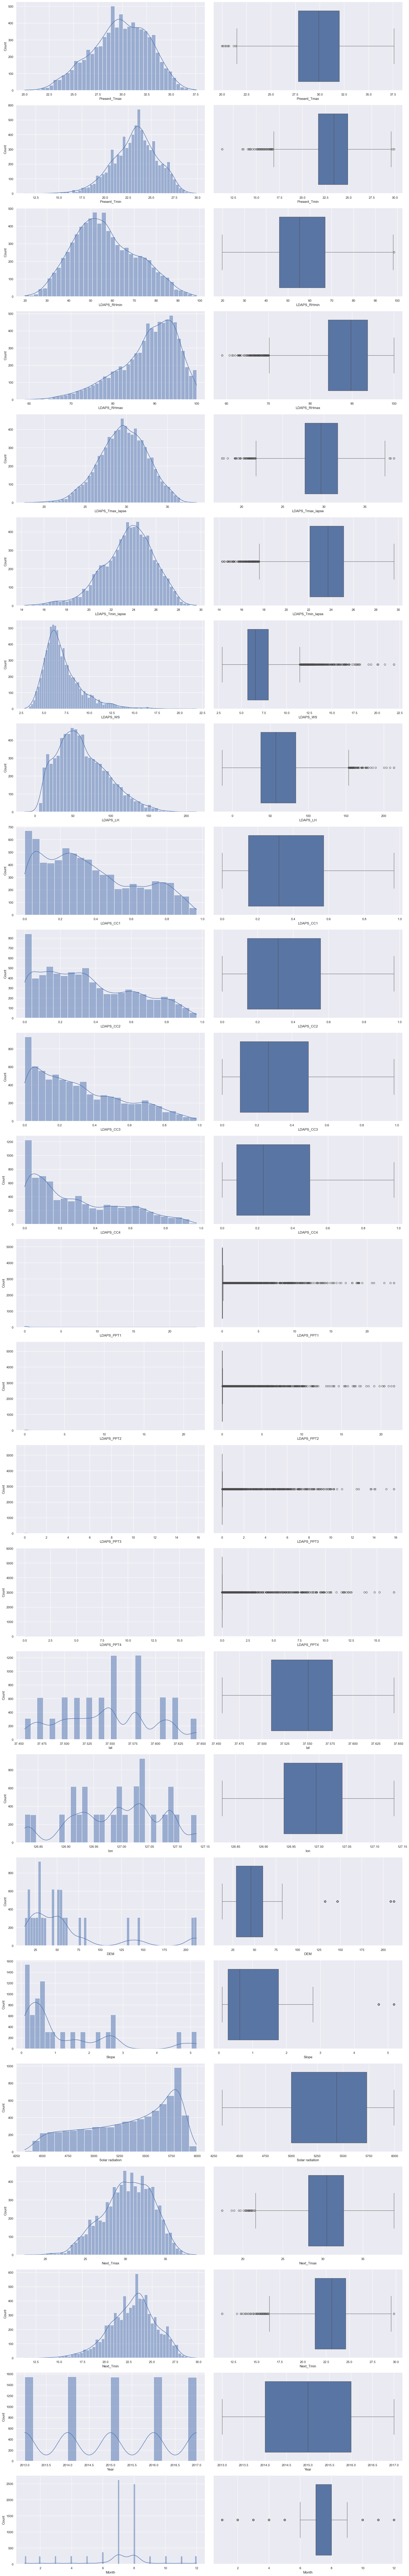

In [41]:
# Distribuição de todas as colunas do conjunto de dados
# Todas as variáveis parecem estar distribuídas normalmente.
# Como temos várias variáveis, vamos tentar identificar o tipo de distribuição

plt.figure(figsize=(20, 5 * len(data0.columns)), facecolor="white")
plotnumber = 1

for column in data0:
    # Verifica se a coluna é numérica
    if pd.api.types.is_numeric_dtype(data0[column]):
        # Histograma (distribuição)
        ax1 = plt.subplot(len(data0.columns), 2, plotnumber)
        sns.histplot(data0[column], kde=True, ax=ax1)
        plt.xlabel(column, fontsize=12)

        # Boxplot
        ax2 = plt.subplot(len(data0.columns), 2, plotnumber + 1)
        sns.boxplot(x=data0[column], ax=ax2)
        plt.xlabel(column, fontsize=12)

        plotnumber += 2

plt.tight_layout()
plt.show()


In [42]:
data0.columns

Index(['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Next_Tmax', 'Next_Tmin', 'Year', 'Month'],
      dtype='object')

# Tratamento dos Outliers

In [43]:
# Aplicando Z-score para identificar e remover outliers
# Considerei as colunas 'Present_Tmax', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope' e 'Solar radiation',
# pois essas apresentaram maior assimetria (skewness).

# 🔎 Tratamento de outliers com Z-score:
# Este bloco aplica o método estatístico do Z-score para detectar e remover outliers extremos em variáveis com alta assimetria.
# 1. Selecionamos as colunas mais sujeitas a valores discrepantes (skewed).
# 2. Calculamos o Z-score, que padroniza os dados com base na média e no desvio padrão.
# 3. Convertemos os valores do Z-score em absolutos para considerar desvios tanto positivos quanto negativos.
# 4. Filtramos as linhas que possuem todos os valores com Z-score < 3 (dentro de 3 desvios padrão da média).
# 5. Atualizamos o DataFrame original, mantendo apenas os dados "limpos".
# Esse processo remove registros extremos e ajuda a melhorar o desempenho do modelo de machine learning.

# 📌 Importa a função zscore para padronização estatística dos dados
from scipy.stats import zscore

# 🧮 Calcula o z-score para as colunas selecionadas (padronização: média 0, desvio padrão 1)
z_score = zscore(data0[['Present_Tmax', 'LDAPS_RHmin', 'LDAPS_RHmax',
                       'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
                       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
                       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope',
                       'Solar radiation']])

# 🔢 Converte todos os valores do z-score para valores absolutos (sem sinal negativo)
abs_zscore = np.abs(z_score)

# ✅ Filtra apenas as entradas onde todas as variáveis têm z-score < 3 (remoção de outliers)
filtering_entry = (abs_zscore < 3).all(axis=1)

# 🧹 Atualiza o DataFrame original mantendo apenas as linhas que passaram no filtro de outliers
data0 = data0[filtering_entry]

# 📊 Exibe as estatísticas descritivas do novo conjunto de dados (sem outliers extremos)
data0.describe()


Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  LDAPS_Tmax_lapse  \
count   6904.000000   6904.000000  6904.000000  6904.000000       6904.000000   
mean      29.921561     23.276438    55.521012    88.070946         29.870628   
std        2.869120      2.360943    13.832299     6.929590          2.744167   
min       21.200000     11.300000    19.794666    66.897522         21.195428   
25%       28.100000     21.700000    45.618697    83.894827         28.008429   
50%       30.000000     23.400000    54.262054    89.170044         29.884542   
75%       32.100000     24.900000    64.928831    93.397106         31.797716   
max       37.600000     29.900000    96.169815    99.999008         38.542255   

       LDAPS_Tmin_lapse     LDAPS_WS     LDAPS_LH    LDAPS_CC1    LDAPS_CC2  \
count       6904.000000  6904.000000  6904.000000  6904.000000  6904.000000   
mean          23.624036     6.865369    62.024188     0.344580     0.330522   
std            2.245041     1.837649    33.224624     0.250441     0.239371   
min           16.517926     2.882580    -8.569043     0.000000     0.000000   
25%           22.198063     5.628352    36.722658     0.137191     0.133668   
50%           23.820666     6.461910    57.287139     0.297788     0.297264   
75%           25.187678     7.730666    84.222469     0.499452     0.509339   
max           29.619342    13.589191   161.661149     0.967277     0.968353   

       ...   LDAPS_PPT4          lat          lon          DEM        Slope  \
count  ...  6904.000000  6904.000000  6904.000000  6904.000000  6904.000000   
mean   ...     0.088528    37.544032   126.990929    61.300961     1.242805   
std    ...     0.361911     0.050126     0.079541    53.672753     1.354583   
min    ...     0.000000    37.456200   126.826000    12.370000     0.098500   
25%    ...     0.000000    37.510200   126.937000    28.700000     0.271300   
50%    ...     0.000000    37.550700   126.995000    45.716000     0.618000   
75%    ...     0.000000    37.577600   127.042000    59.832400     1.767800   
max    ...     3.789353    37.645000   127.135000   212.335000     5.178200   

       Solar radiation    Next_Tmax    Next_Tmin         Year        Month  
count      6904.000000  6904.000000  6904.000000  6904.000000  6904.000000  
mean       5339.273003    30.547262    23.049942  2014.995510     7.089948  
std         422.418907     2.946644     2.409667     1.399119     2.242283  
min        4371.684570    20.800000    13.300000  2013.000000     1.000000  
25%        5014.173828    28.600000    21.500000  2014.000000     7.000000  
50%        5428.586426    30.700000    23.200000  2015.000000     7.000000  
75%        5717.971558    32.700000    24.700000  2016.000000     8.000000  
max        5992.895996    38.900000    29.800000  2017.000000    12.000000  

[8 rows x 25 columns]

In [44]:
# Porcentagem de perda de dados
# Neste caso, estamos perdendo cerca de 10,62% dos dados após aplicar o z-score.
# Ao remover esses dados, obtivemos uma melhor acurácia no modelo.
# Idealmente, não é uma boa prática descartar uma quantidade tão grande de dados mas, neste caso específico, manter os outliers resultou em um desempenho inferior do modelo.
# Por isso, os dados considerados outliers foram removidos completamente.

loss_percent = (7725-6904)/7725*100
print(loss_percent)
10.627831715210355

10.627831715210355


10.627831715210355

# Correlação das variáveis - ver também o Profile Pandas

### Correlação das variáveis com as duas variáveis dependentes

In [45]:
# Correlação das variáveis com as variáveis dependentes "Next_Tmax" e "Next_Tmin"
corr_matrix = data0.corr()
corr_matrix[["Next_Tmax", "Next_Tmin"]]

Next_Tmax  Next_Tmin
Present_Tmax       0.589422   0.618314
Present_Tmin       0.454487   0.791869
LDAPS_RHmin       -0.420328   0.145484
LDAPS_RHmax       -0.294704  -0.085369
LDAPS_Tmax_lapse   0.808703   0.551174
LDAPS_Tmin_lapse   0.544994   0.872281
LDAPS_WS          -0.276988  -0.015534
LDAPS_LH           0.167502  -0.056139
LDAPS_CC1         -0.444295   0.016623
LDAPS_CC2         -0.472727   0.087311
LDAPS_CC3         -0.482144   0.005922
LDAPS_CC4         -0.421009  -0.041453
LDAPS_PPT1        -0.223902  -0.023103
LDAPS_PPT2        -0.200552   0.010444
LDAPS_PPT3        -0.125766   0.027208
LDAPS_PPT4        -0.149026  -0.098500
lat               -0.049081  -0.079274
lon                0.005845  -0.050852
DEM               -0.157636  -0.241504
Slope             -0.088350  -0.141471
Solar radiation   -0.020947   0.091172
Next_Tmax          1.000000   0.587031
Next_Tmin          0.587031   1.000000
Year               0.094485   0.058585
Month             -0.013465  -0.025023

### Heatmap correlação

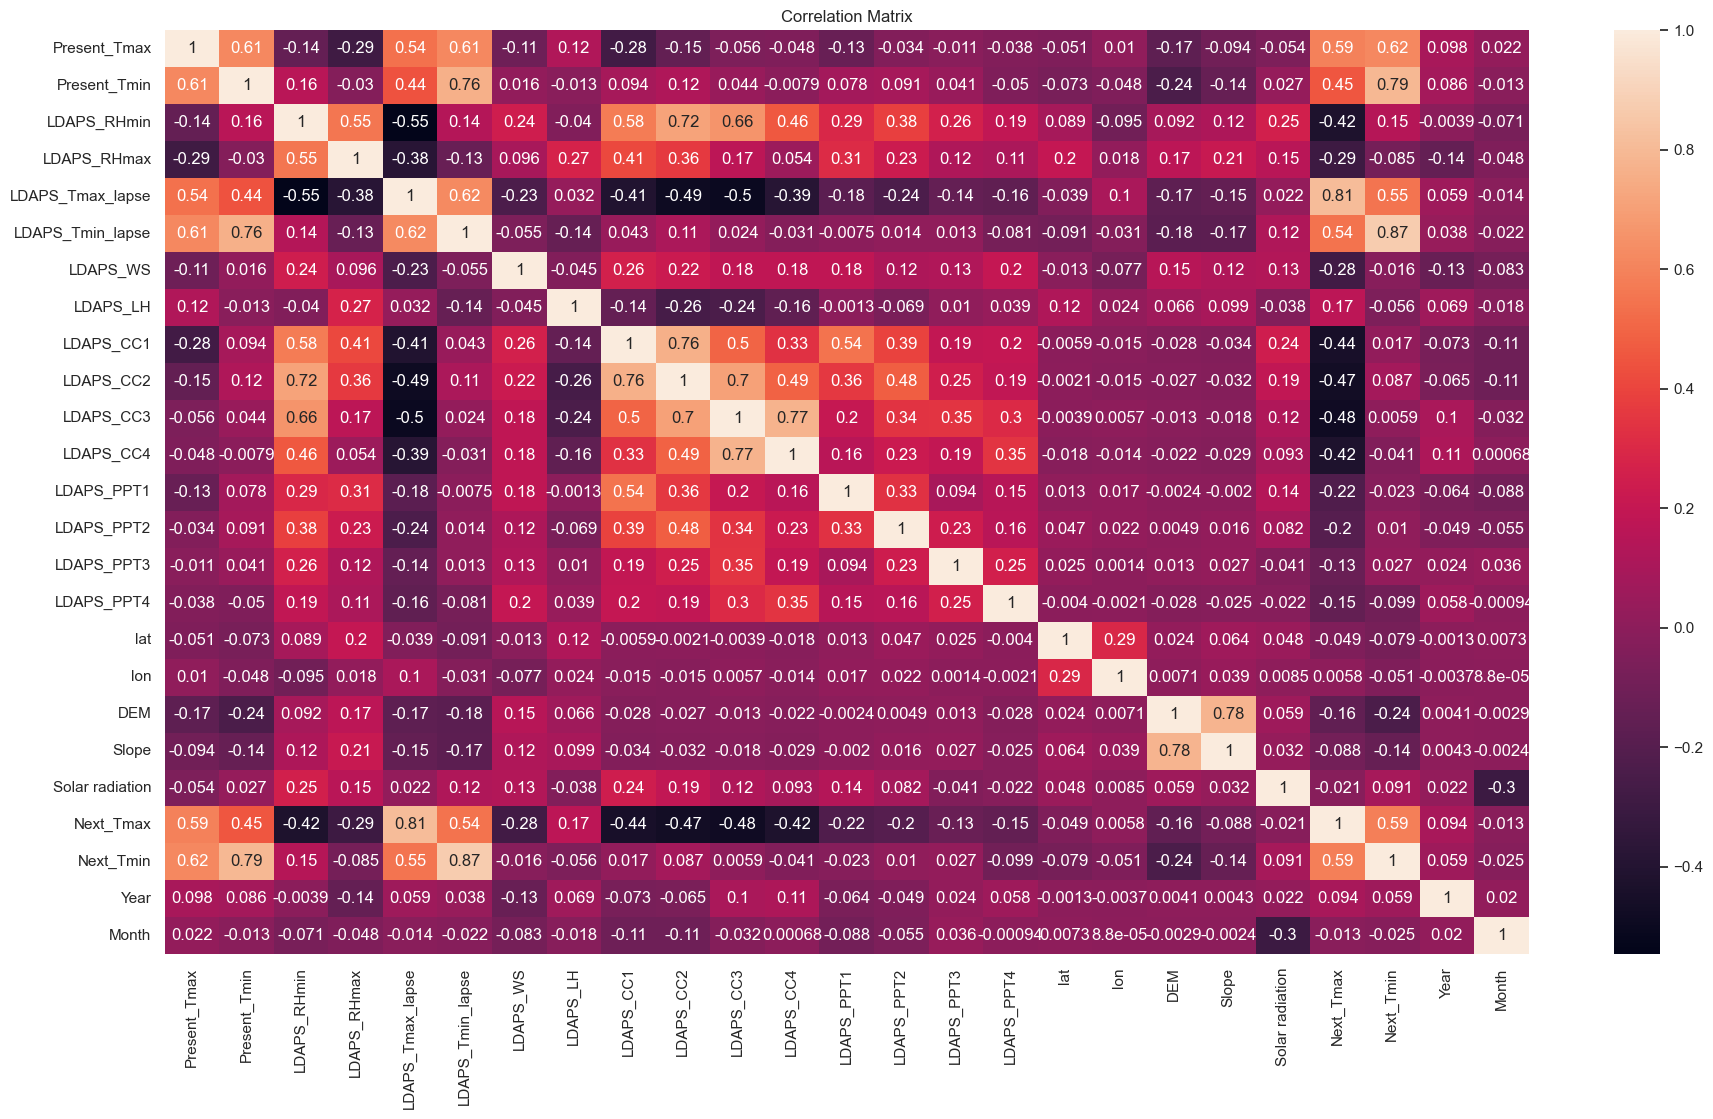

In [46]:
# Vamos agora examinar a correlação usando um "heatmap" (mapa de calor) para melhor visualização
# Como há muitas variáveis, a análise deste gráfico pode parecer um pouco difícil
plt.figure(figsize=(22,12))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

# Separação dados em Treino e Teste

In [47]:
# Separação do conjunto de dados entre x (variáveis independentes) e y (colunas-alvo)
# Como os valores-alvo possuem 2 variáveis do mesmo tipo de dado, a coluna "y" é dividida da seguinte forma
x = data0.drop(columns = ["Next_Tmax", "Next_Tmin"], axis=1)
y = data0[["Next_Tmax", "Next_Tmin"]]
df_teste = pd.concat([x, y], axis=1)
df_teste.to_csv("teste.csv", index=False)
print("✅ Arquivo 'teste.csv' criado com entrada e saída.")

✅ Arquivo 'teste.csv' criado com entrada e saída.


# Avaliação da Assimetria dos dados

### Demonstração de Assimétric0 + | Assimétrico - | Simétrico

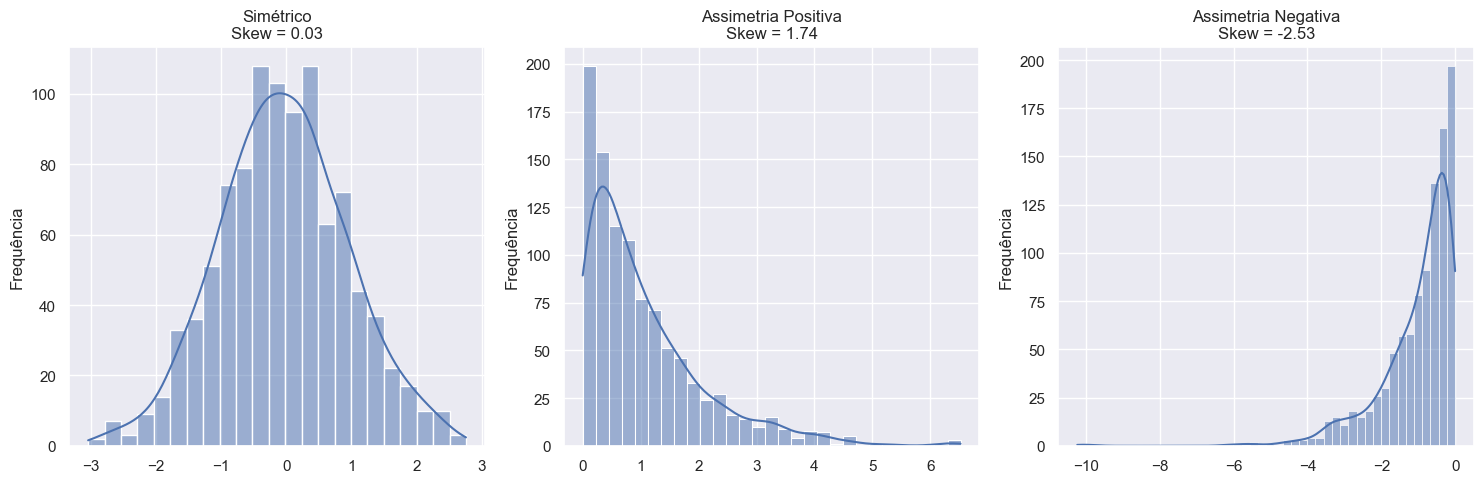

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# Criando dados com diferentes assimetrias
np.random.seed(0)

# Distribuição simétrica (skew ≈ 0)
simetrico = np.random.normal(loc=0, scale=1, size=1000)

# Assimetria positiva (cauda à direita)
assim_pos = np.random.exponential(scale=1, size=1000)

# Assimetria negativa (inverter a positiva)
assim_neg = -np.random.exponential(scale=1, size=1000)

# Criar DataFrame
df_skew = pd.DataFrame({
    "Simétrico": simetrico,
    "Assimetria Positiva": assim_pos,
    "Assimetria Negativa": assim_neg
})

# Plotar
plt.figure(figsize=(15, 5))

for i, column in enumerate(df_skew.columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_skew[column], kde=True)
    plt.title(f"{column}\nSkew = {df_skew[column].skew():.2f}")
    plt.xlabel('')
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


### Avaliação da assimetria geral

In [49]:
# Verificação da assimetria (skewness) dos dados após a separação
# Podemos observar que todos os valores apresentam assimetria, mesmo após a remoção dos outliers
# As colunas "lat", "lon", "Month" e "Year" não estão sendo consideradas nessa análise
x.skew()

Present_Tmax       -0.278724
Present_Tmin       -0.333060
LDAPS_RHmin         0.307051
LDAPS_RHmax        -0.684618
LDAPS_Tmax_lapse   -0.106446
LDAPS_Tmin_lapse   -0.410665
LDAPS_WS            1.085527
LDAPS_LH            0.561378
LDAPS_CC1           0.596271
LDAPS_CC2           0.506058
LDAPS_CC3           0.701620
LDAPS_CC4           0.710085
LDAPS_PPT1          3.742993
LDAPS_PPT2          4.855280
LDAPS_PPT3          5.516516
LDAPS_PPT4          5.906318
lat                 0.102755
lon                -0.278256
DEM                 1.755616
Slope               1.588262
Solar radiation    -0.506093
Year                0.007356
Month              -0.684306
dtype: float64

### Avaliação gráfica da assimetria

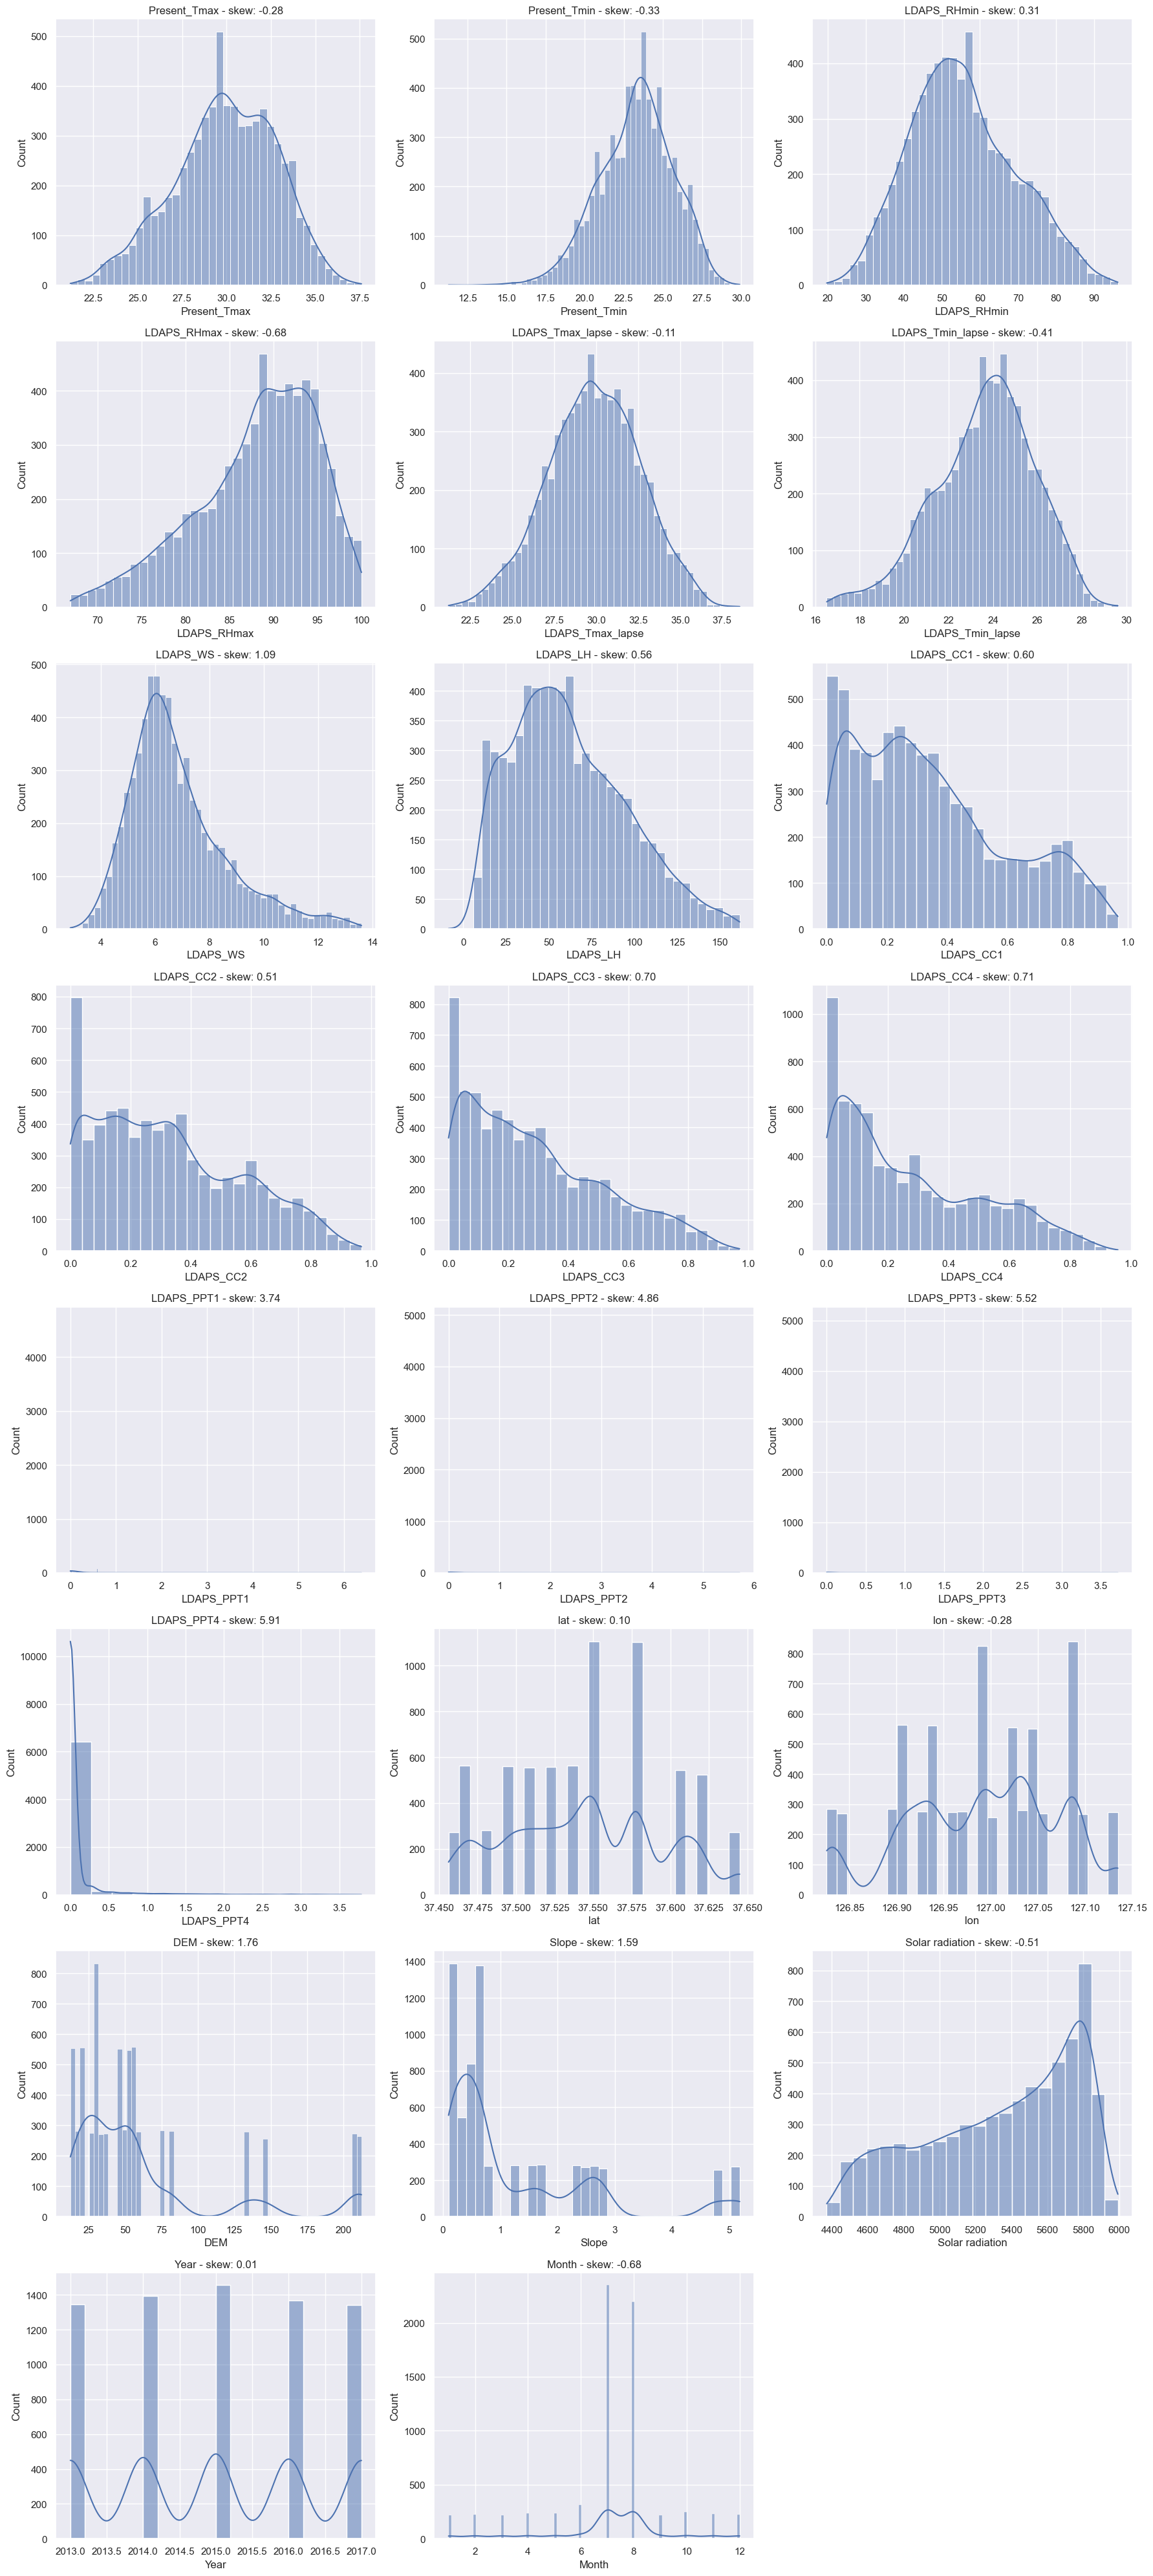

In [50]:
# Seleciona apenas colunas numéricas
numeric_cols = x.select_dtypes(include='number').columns
# Número de colunas por linha
cols_por_linha = 3
n = len(numeric_cols)
linhas = (n + cols_por_linha - 1) // cols_por_linha  # arredonda para cima

# Cria os subplots
fig, axes = plt.subplots(linhas, cols_por_linha, figsize=(18, 5 * linhas))
axes = axes.flatten()  # transforma em vetor para facilitar iteração

# Gera os gráficos
for i, coluna in enumerate(numeric_cols):
    sns.histplot(x[coluna], kde=True, ax=axes[i])
    axes[i].set_title(f"{coluna} - skew: {x[coluna].skew():.2f}")

# Remove eixos vazios, se houver
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [51]:
# Armazenando a lista de variáveis com assimetria em uma variável chamada "feat_skew"
# Isso facilita o reaproveitamento da lista, permitindo passar todas as colunas de uma vez para funções como zscore ou visualizações
# Lista de variáveis com maior assimetria (skewness)
# Estas colunas foram identificadas como tendo distribuições assimétricas ou com tendência a outliers.
# Armazenamos todas elas na variável "feat_skew" para facilitar o uso em etapas como padronização (z-score),
# análise estatística ou visualizações futuras de forma automatizada.

feat_skew = ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
               'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
               'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
               'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope',
               'Solar radiation']

# Padronização das Variáveis com Stand Scaler

### Processar a padronização de variáveis


In [52]:
# Vamos agora escalonar os dados para o processamento posterior.
# Utilizamos o StandardScaler para padronizar os dados, transformando as variáveis para que tenham média 0 e desvio padrão 1, 
# o que é essencial para algoritmos de machine learning que são sensíveis à escala dos dados.

# Aplicando a padronização dos dados com StandardScaler
# O StandardScaler transforma os dados para que cada variável tenha média 0 e desvio padrão 1.
# Isso é importante para algoritmos que são sensíveis à escala das variáveis (como regressão, SVM, KNN etc.).
# O método fit_transform ajusta o scaler aos dados de entrada (x) e já os transforma.
# O resultado (x_scaled) é um array NumPy com os dados padronizados.

from sklearn.preprocessing import StandardScaler
import joblib

# Ajustar o scaler aos seus dados de entrada
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Salvar o scaler treinado para uso futuro no Streamlit
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

### Ilustrativo da padronização de dados

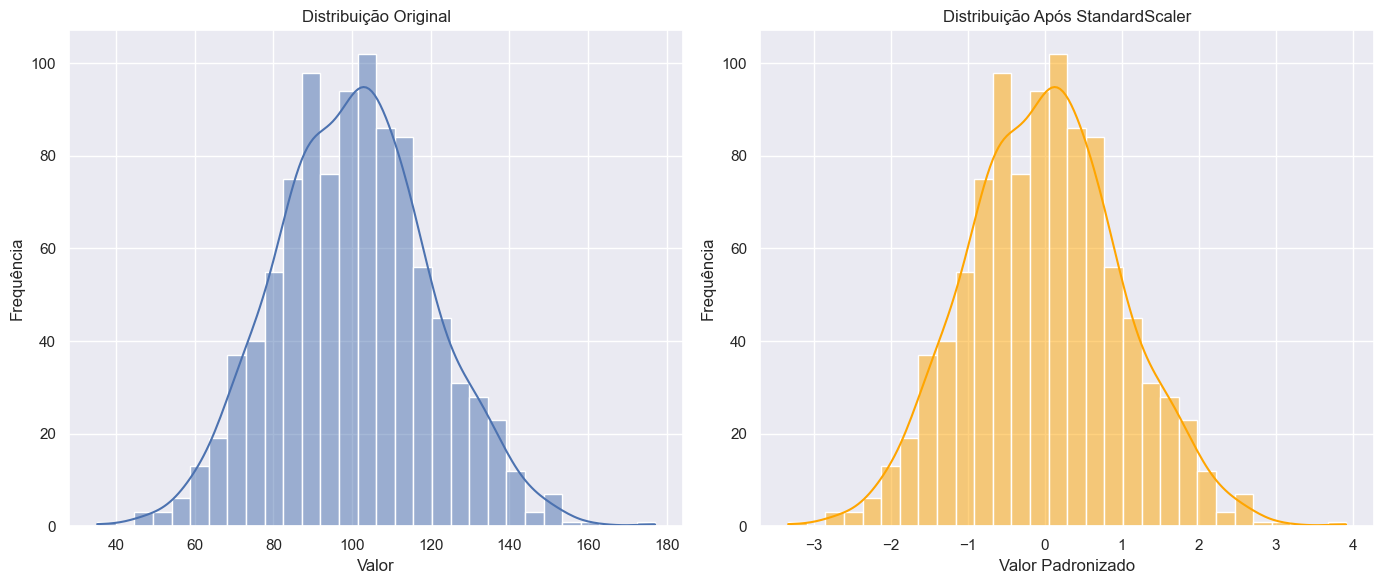

In [53]:
# Ilustrativo

# Criando dados fictícios (distribuição normal com média 100 e desvio 20)
np.random.seed(42)
dados_originais = np.random.normal(loc=100, scale=20, size=1000)
df = pd.DataFrame({'Original': dados_originais})

# Aplicando StandardScaler
scaler = StandardScaler()
df['Padronizado'] = scaler.fit_transform(df[['Original']])

# Plotando os histogramas
plt.figure(figsize=(14, 6))

# Original
plt.subplot(1, 2, 1)
sns.histplot(df['Original'], kde=True, bins=30)
plt.title('Distribuição Original')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Padronizado
plt.subplot(1, 2, 2)
sns.histplot(df['Padronizado'], kde=True, bins=30, color='orange')
plt.title('Distribuição Após StandardScaler')
plt.xlabel('Valor Padronizado')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


### Visualizar os dados padronizados do dataset

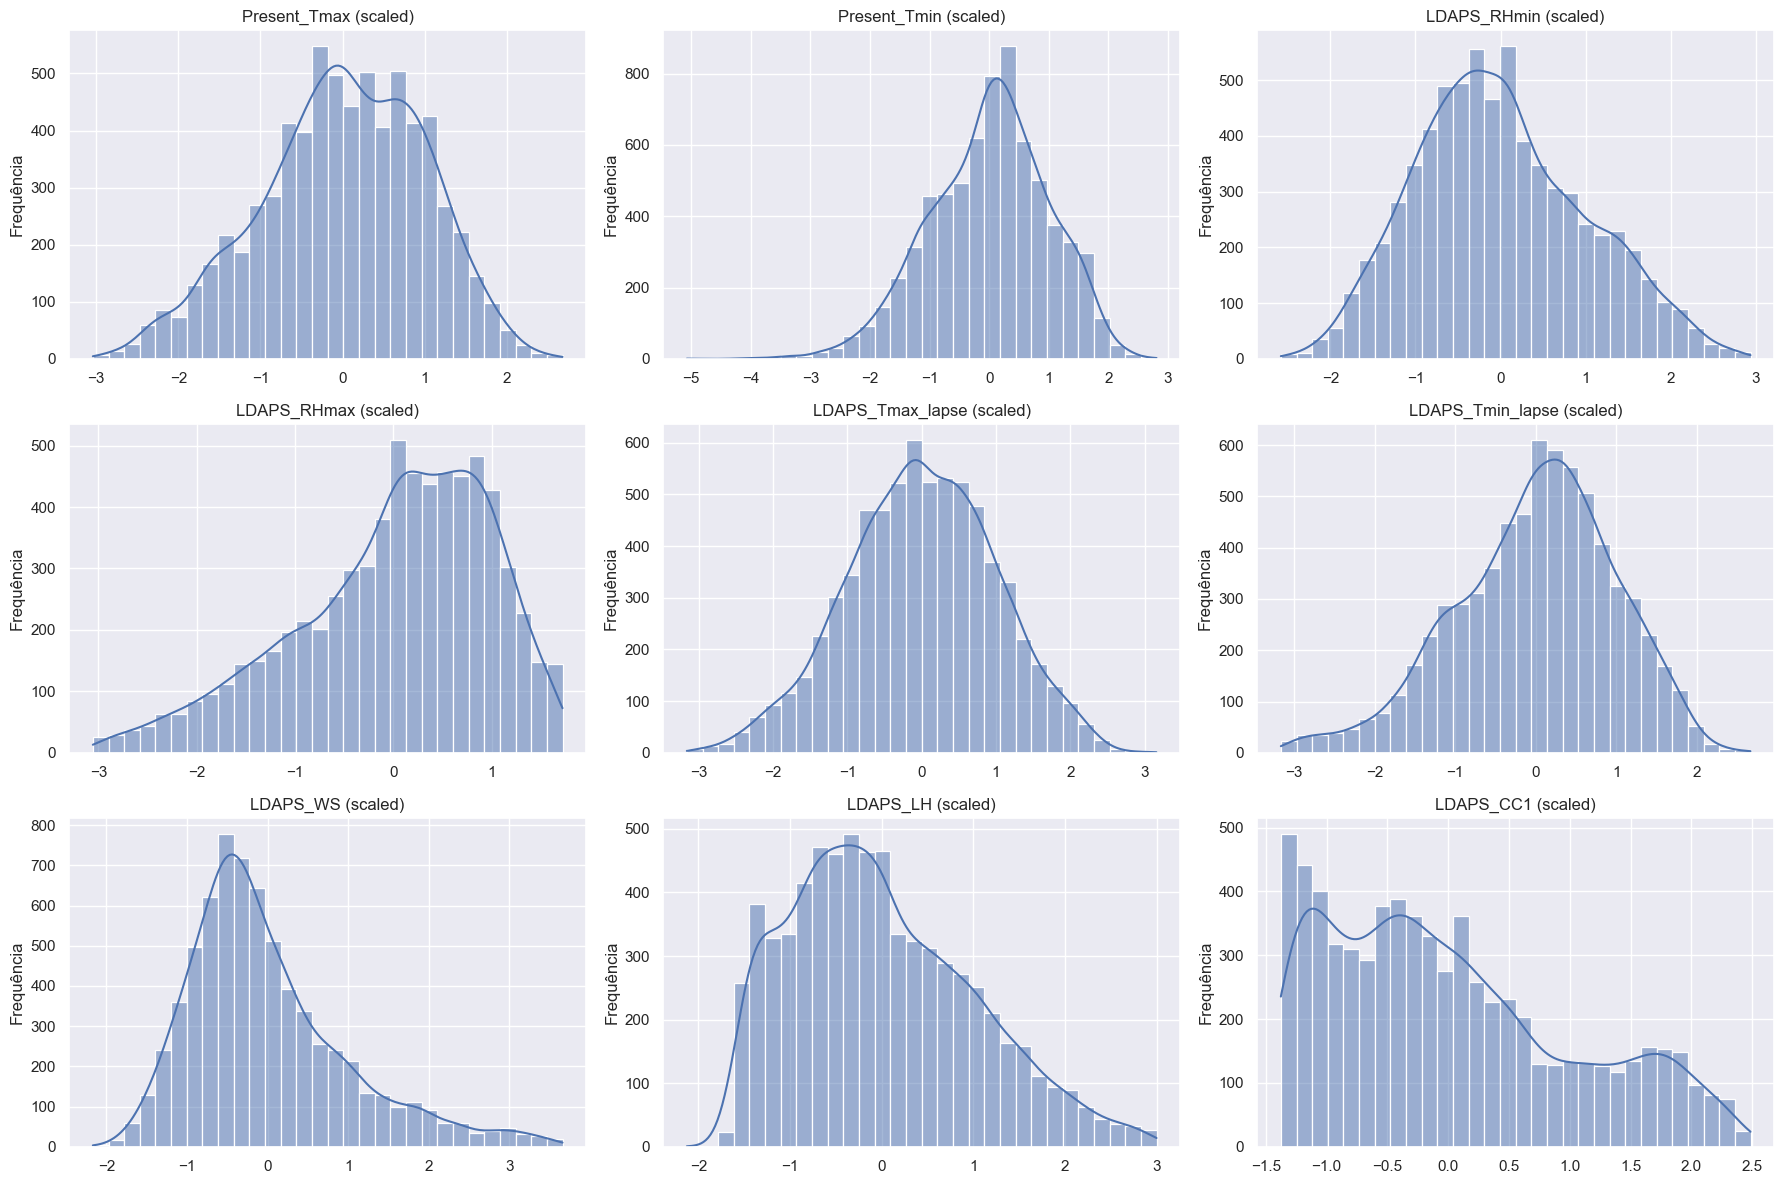

In [54]:
# Converte o array x_scaled de volta para um DataFrame com os mesmos nomes de coluna
x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)

# Plota os histogramas das variáveis padronizadas
plt.figure(figsize=(18, 12))
for i, col in enumerate(x_scaled_df.columns[:9]):  # Limita para 9 variáveis (3x3), mas você pode ajustar
    plt.subplot(3, 3, i + 1)
    sns.histplot(x_scaled_df[col], kde=True, bins=30)
    plt.title(f'{col} (scaled)')
    plt.xlabel('')
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


# Redução da Assimetria dos dados

In [55]:
# Power Transformer  (Yeo-Johnson)
# Para reduzir a assimetria (skewness) dos dados, utilizamos a técnica de Power Transformer.
# Como o conjunto de dados possui valores positivos e negativos, aplicamos a transformação do tipo "Yeo-Johnson", que é adequada para dados com ambos os sinais (diferente de Box-Cox, que só aceita valores positivos).
# Após a transformação, os dados também são padronizados (média 0, desvio padrão 1), contribuindo para melhorar a distribuição e a performance de alguns modelos de machine learning.

# Aplicando PowerTransformer com o método Yeo-Johnson
# Importa o PowerTransformer da biblioteca sklearn para transformar os dados com alta assimetria.
# Usamos o método "yeo-johnson", que é adequado para dados com valores positivos e negativos.
# Aplicamos a transformação apenas nas colunas armazenadas em "feat_skew", que foram previamente identificadas como assimétricas.
# A transformação reduz a skewness e padroniza os dados (média 0, desvio padrão 1),
# melhorando a distribuição e facilitando o desempenho de modelos sensíveis à normalidade.


from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method="yeo-johnson")

x[feat_skew] = scaler.fit_transform(x[feat_skew].values) 

x[feat_skew]

Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  LDAPS_Tmax_lapse  \
0        -0.473778     -0.827105     0.261547     0.351620         -0.666609   
1         0.670455     -0.748201    -0.170814     0.264025         -0.025317   
2         0.557621     -0.045452    -0.441370    -0.720625          0.062704   
3         0.708324     -0.002320     0.260432     1.383668         -0.078615   
4         0.483040     -0.628359     0.114184     0.188513         -0.293121   
...            ...           ...          ...          ...               ...   
7745     -2.164617     -2.113033    -2.628259    -1.371661         -0.759663   
7746     -2.322572     -2.240337    -2.061009    -0.756942         -1.150221   
7747     -2.110975     -2.333790    -2.405861    -1.309970         -1.273305   
7748     -2.110975     -2.145148    -2.700525    -1.466154         -1.043207   
7749     -2.137858     -2.240337    -2.826385    -1.471046         -0.714561   

      LDAPS_Tmin_lapse  LDAPS_WS  LDAPS_LH  LDAPS_CC1  LDAPS_CC2  LDAPS_CC3  \
0            -0.347306  0.169382  0.345994  -0.311019  -0.430088  -0.469294   
1             0.117419 -0.585150 -0.174407  -0.352357  -0.195801  -0.482573   
2             0.369251 -0.261516 -1.390056  -0.433145  -0.168968  -0.230572   
3            -0.206243 -0.617422  0.241129  -0.397755  -0.319898  -0.472468   
4            -0.134312 -0.552260  1.302920  -0.741309  -0.204210  -0.369958   
...                ...       ...       ...        ...        ...        ...   
7745         -2.102135  0.040162 -2.023667  -1.342961  -1.439480  -1.610637   
7746         -2.251380 -0.527274  0.684537  -1.253560  -1.477354  -1.610632   
7747         -1.952158 -0.254196  0.417781  -1.499066  -1.114338  -1.610637   
7748         -1.965765  0.002793 -0.327741  -1.458548  -1.151725  -1.610637   
7749         -2.033047  0.430800 -2.060675  -1.369431  -1.246287  -1.610637   

      LDAPS_CC4  LDAPS_PPT1  LDAPS_PPT2  LDAPS_PPT3  LDAPS_PPT4       DEM  \
0     -0.521295   -0.537257   -0.496479   -0.474461   -0.428984  1.850383   
1     -0.541458   -0.537257   -0.496479   -0.474461   -0.428984  0.063695   
2     -0.451998   -0.537257   -0.496479   -0.474461   -0.428984 -0.359284   
3     -0.500546   -0.537257   -0.496479   -0.474461   -0.428984  0.092755   
4     -0.287337   -0.537257   -0.496479   -0.474461   -0.428984 -0.284709   
...         ...         ...         ...         ...         ...       ...   
7745  -1.459346   -0.537257   -0.496479   -0.474461   -0.428984 -0.718470   
7746  -1.345301   -0.537257   -0.496479   -0.474461   -0.428984 -1.004784   
7747  -1.497838   -0.537257   -0.496479   -0.474461   -0.428984 -1.580888   
7748  -1.497838   -0.537257   -0.496479   -0.474461   -0.428984 -1.402126   
7749  -1.490807   -0.537257   -0.496479   -0.474461   -0.428984 -1.193172   

         Slope  Solar radiation  
0     1.325729         1.883896  
1    -0.379530         1.430775  
2    -0.947710         1.410514  
3     1.246922         1.387408  
4    -0.396037         1.396467  
...        ...              ...  
7745 -0.273016        -1.760487  
7746 -1.357015        -1.778394  
7747 -1.281951        -1.776503  
7748 -1.072567        -1.782682  
7749 -0.933471        -1.766403  

[6904 rows x 19 columns]

#### Gráfico das transformações

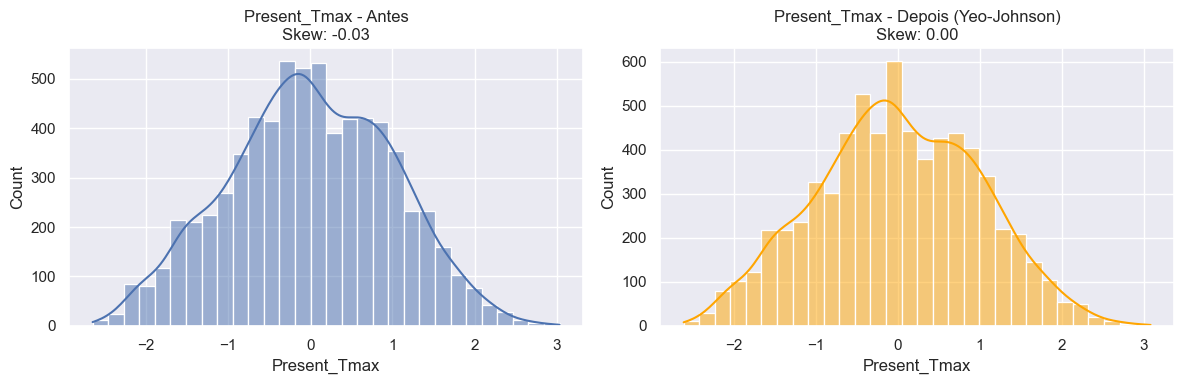

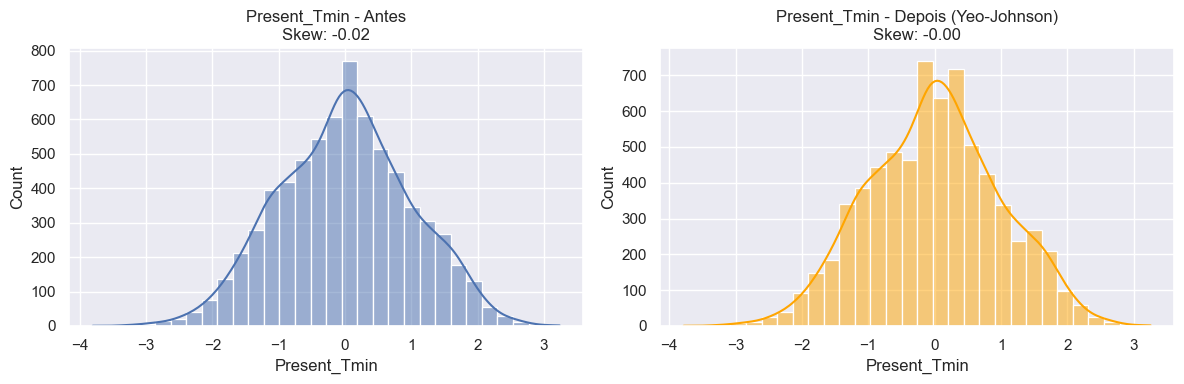

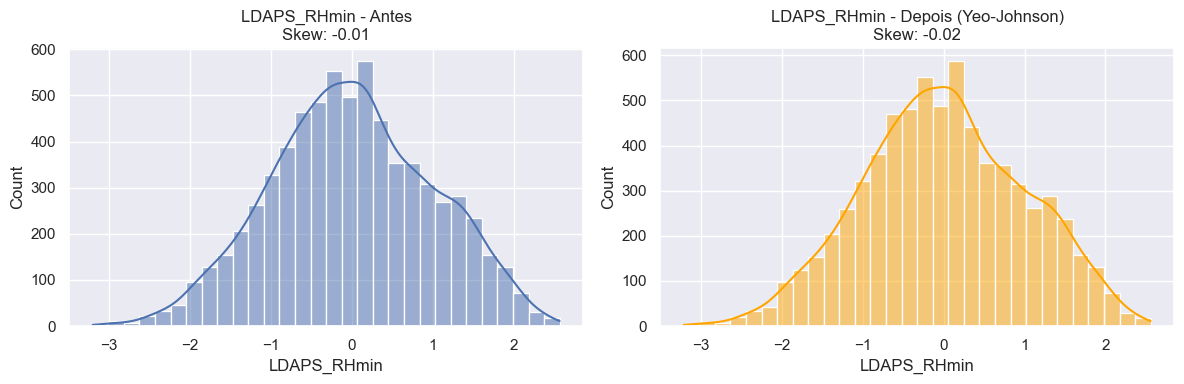

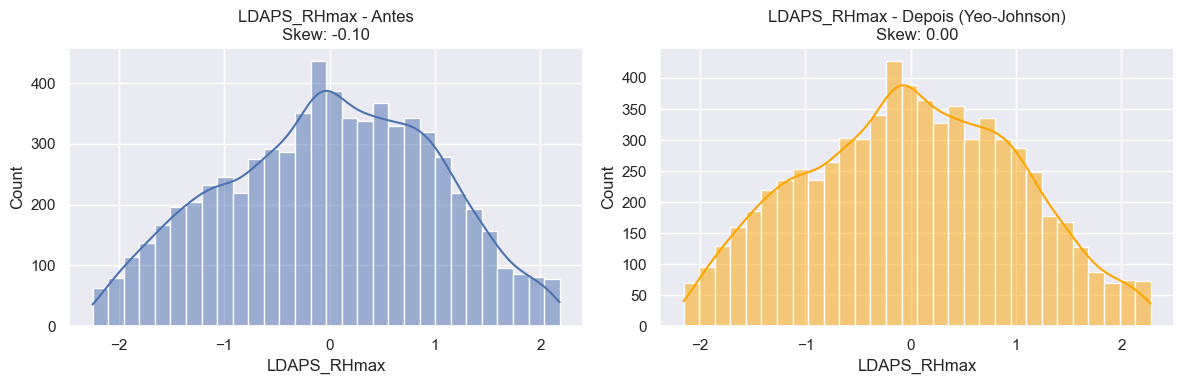

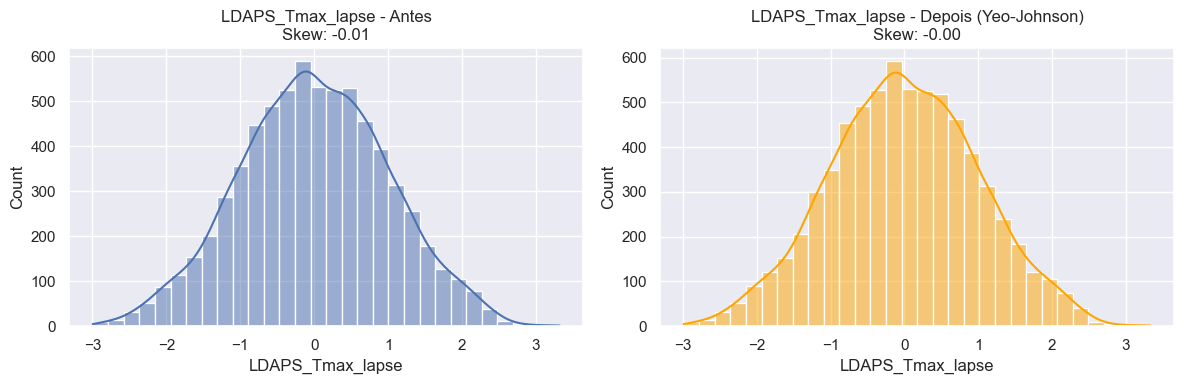

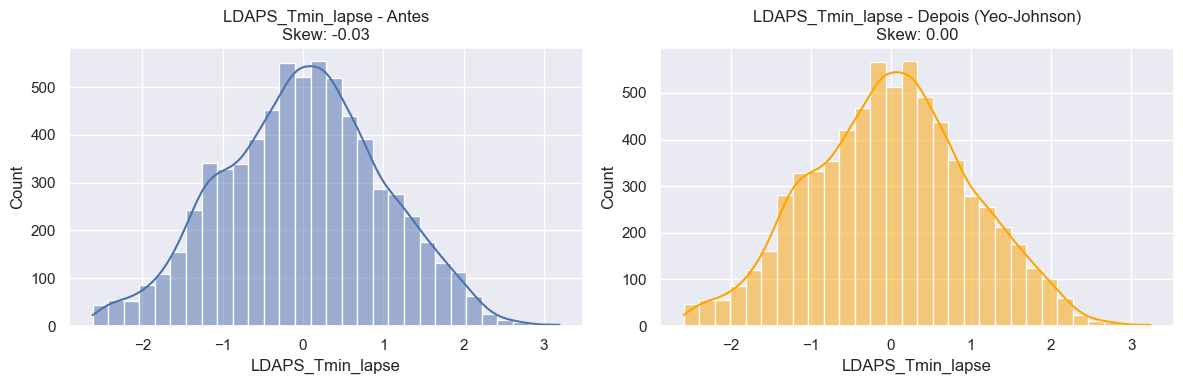

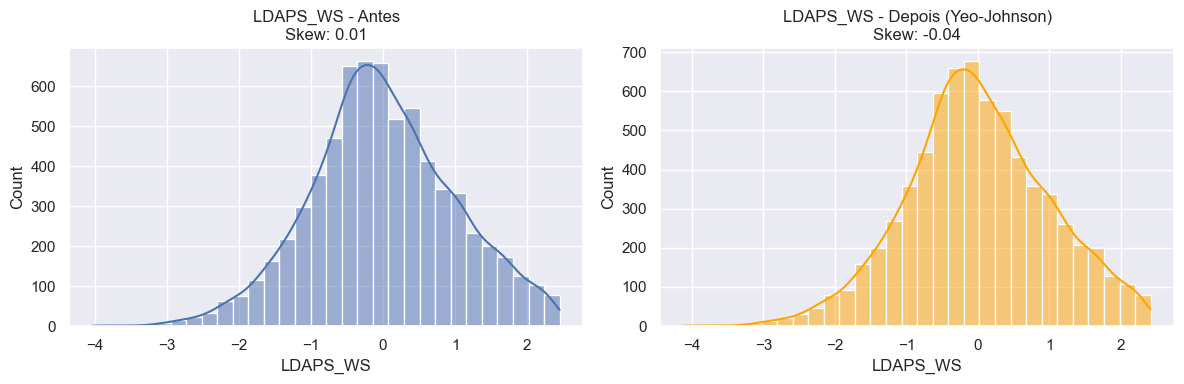

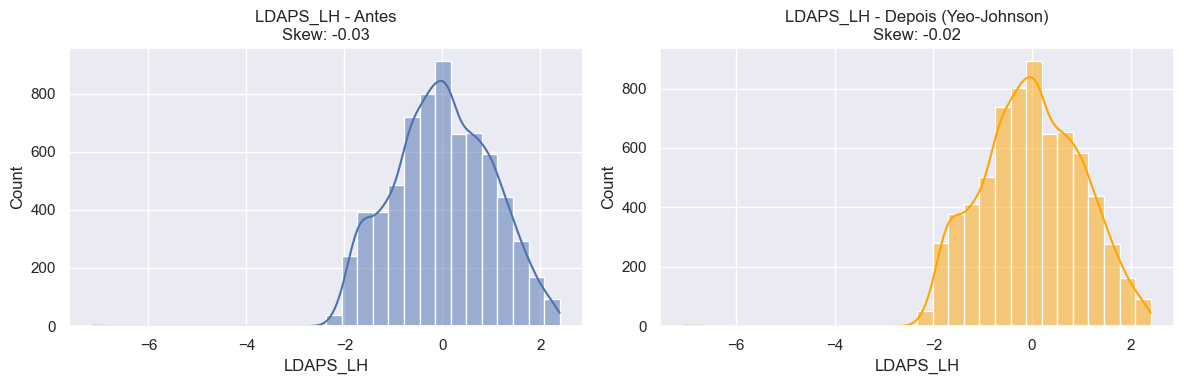

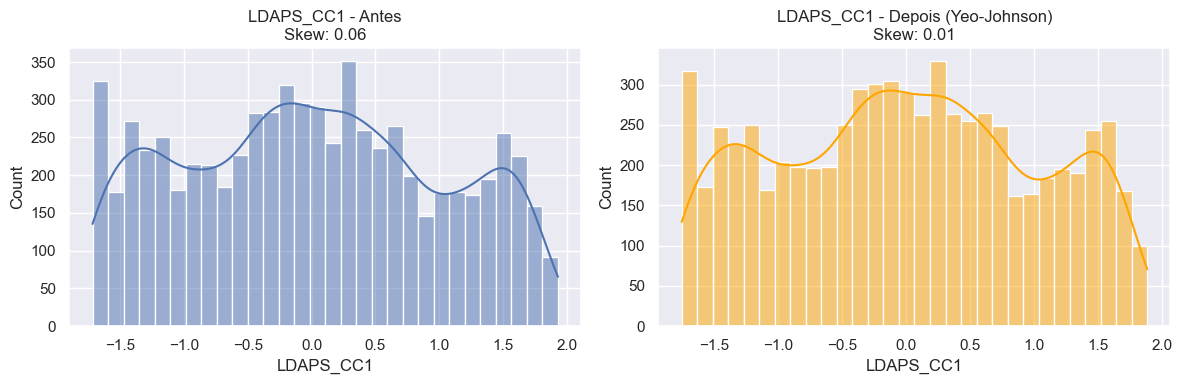

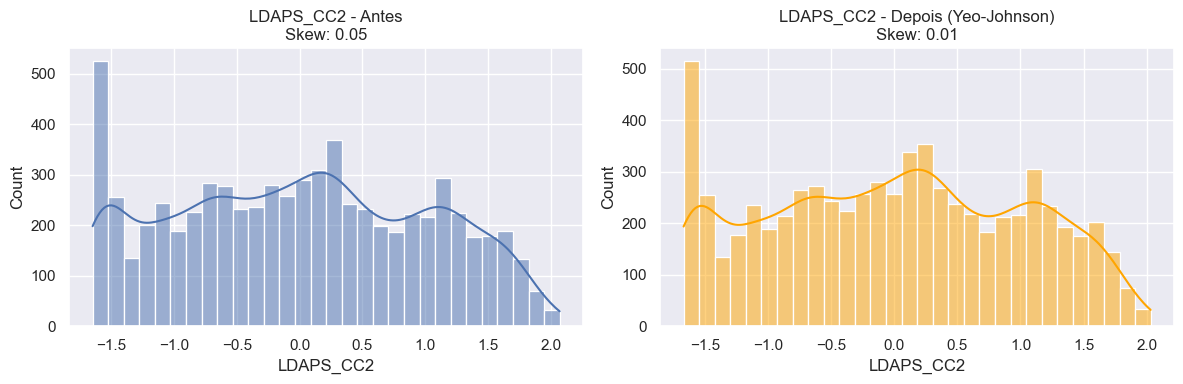

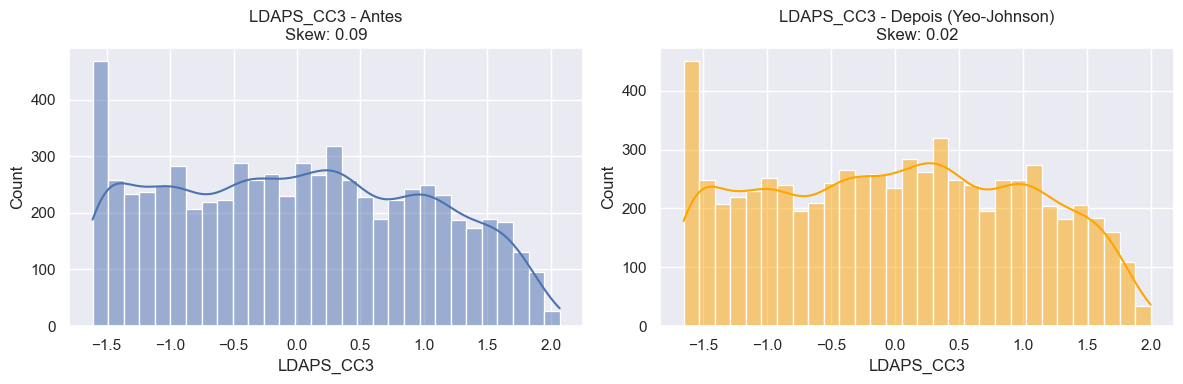

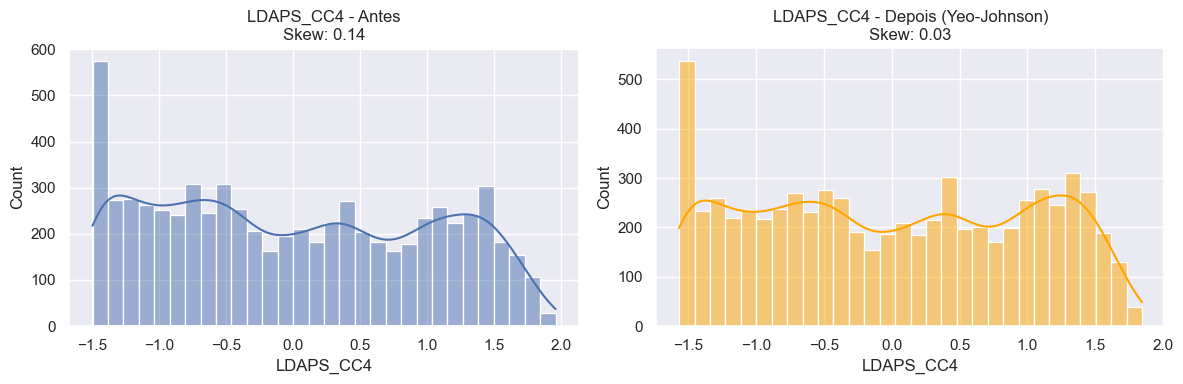

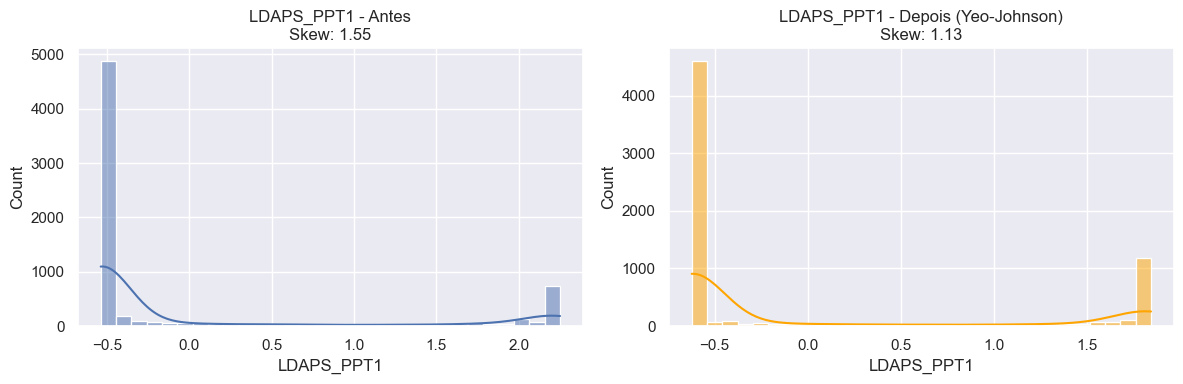

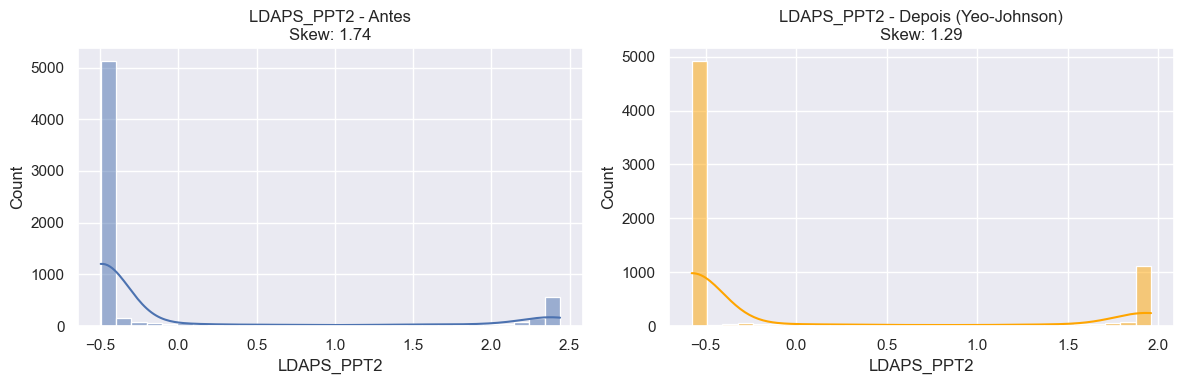

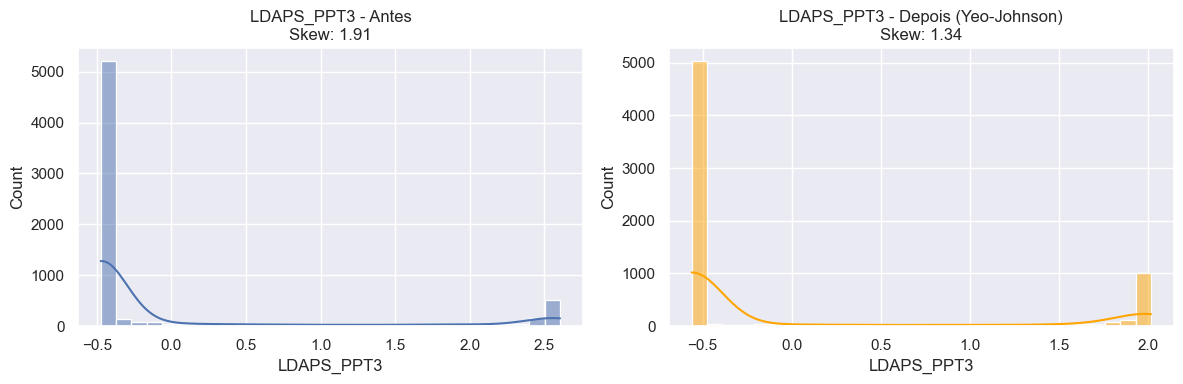

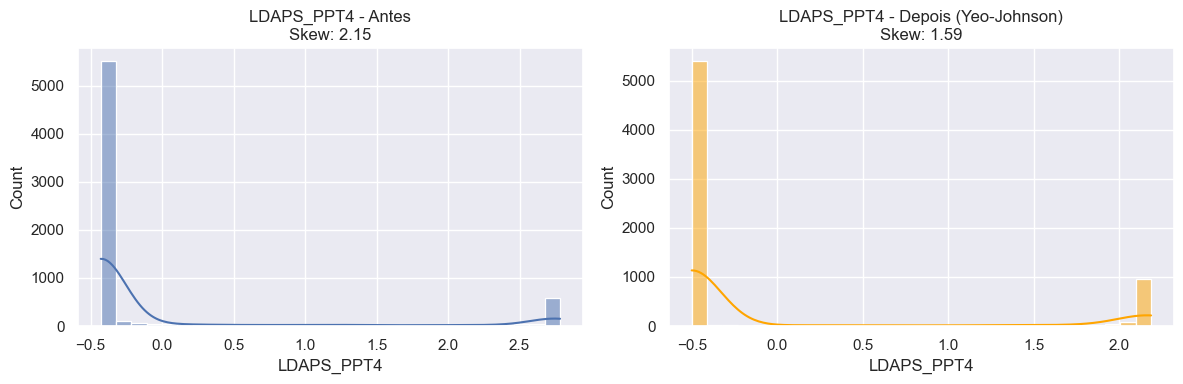

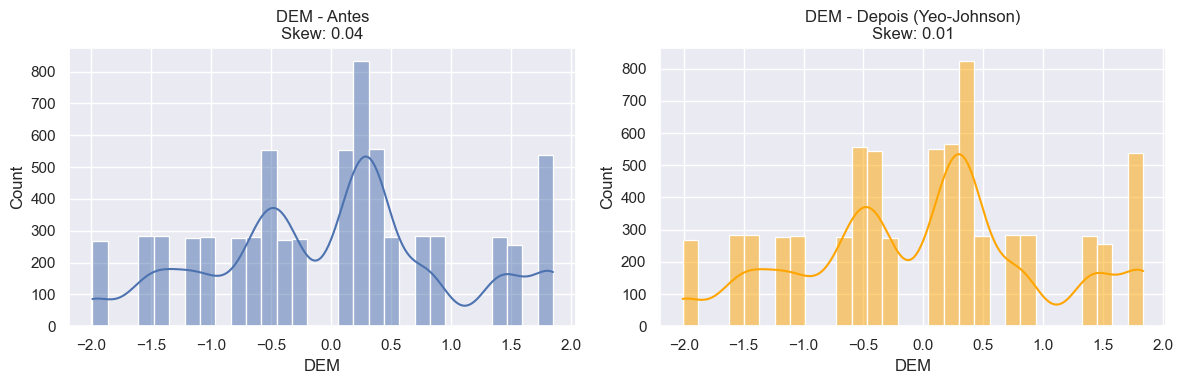

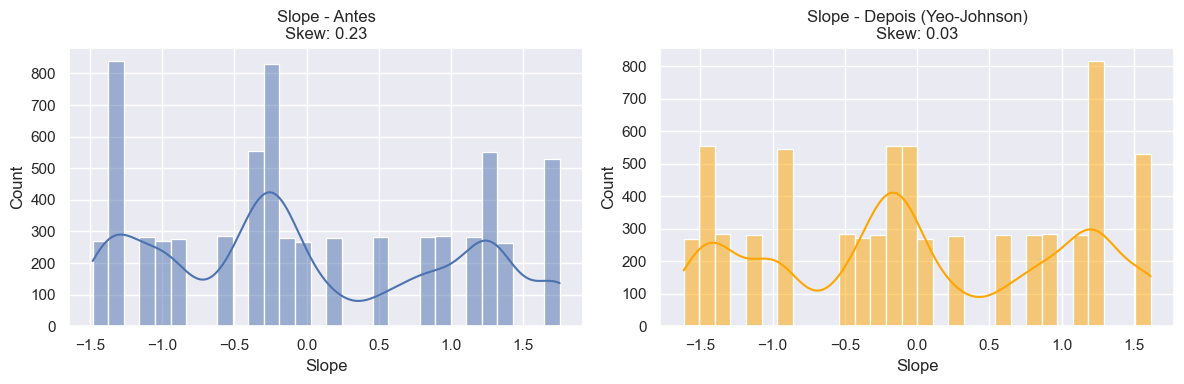

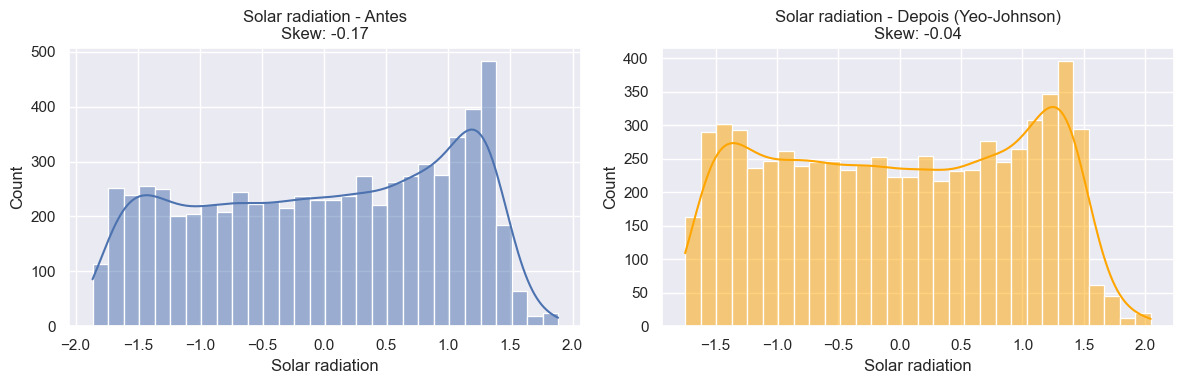

In [56]:
# Criar uma cópia para preservar os dados originais
x_original = x[feat_skew].copy()

# Aplicar PowerTransformer (Yeo-Johnson)
scaler = PowerTransformer(method="yeo-johnson")
x_transformado = scaler.fit_transform(x_original)

# Converter para DataFrame para facilitar os gráficos
x_transformado_df = pd.DataFrame(x_transformado, columns=feat_skew)

# Plotar os histogramas antes e depois, para cada coluna
for coluna in feat_skew:
    plt.figure(figsize=(12, 4))

    # Antes da transformação
    plt.subplot(1, 2, 1)
    sns.histplot(x_original[coluna], kde=True, bins=30)
    plt.title(f"{coluna} - Antes\nSkew: {x_original[coluna].skew():.2f}")

    # Depois da transformação
    plt.subplot(1, 2, 2)
    sns.histplot(x_transformado_df[coluna], kde=True, bins=30, color='orange')
    plt.title(f"{coluna} - Depois (Yeo-Johnson)\nSkew: {x_transformado_df[coluna].skew():.2f}")

    plt.tight_layout()
    plt.show()


In [57]:
# Verificação da assimetria (skewness) do conjunto de variáveis
# A assimetria parece ter sido reduzida consideravelmente após a transformação, mesmo que não tenha sido eliminada por completo
x.skew()

Present_Tmax       -0.032482
Present_Tmin       -0.016196
LDAPS_RHmin        -0.013708
LDAPS_RHmax        -0.098921
LDAPS_Tmax_lapse   -0.010740
LDAPS_Tmin_lapse   -0.026176
LDAPS_WS            0.006013
LDAPS_LH           -0.031128
LDAPS_CC1           0.063066
LDAPS_CC2           0.047678
LDAPS_CC3           0.090323
LDAPS_CC4           0.137699
LDAPS_PPT1          1.550708
LDAPS_PPT2          1.744196
LDAPS_PPT3          1.905510
LDAPS_PPT4          2.150483
lat                 0.102755
lon                -0.278256
DEM                 0.038605
Slope               0.233011
Solar radiation    -0.167600
Year                0.007356
Month              -0.684306
dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_29332\1055021932.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x[column], color="green")
C:\Users\User\AppData\Local\Temp\ipykernel_29332\1055021932.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x[column], color="green")
C:\Users\User\AppD

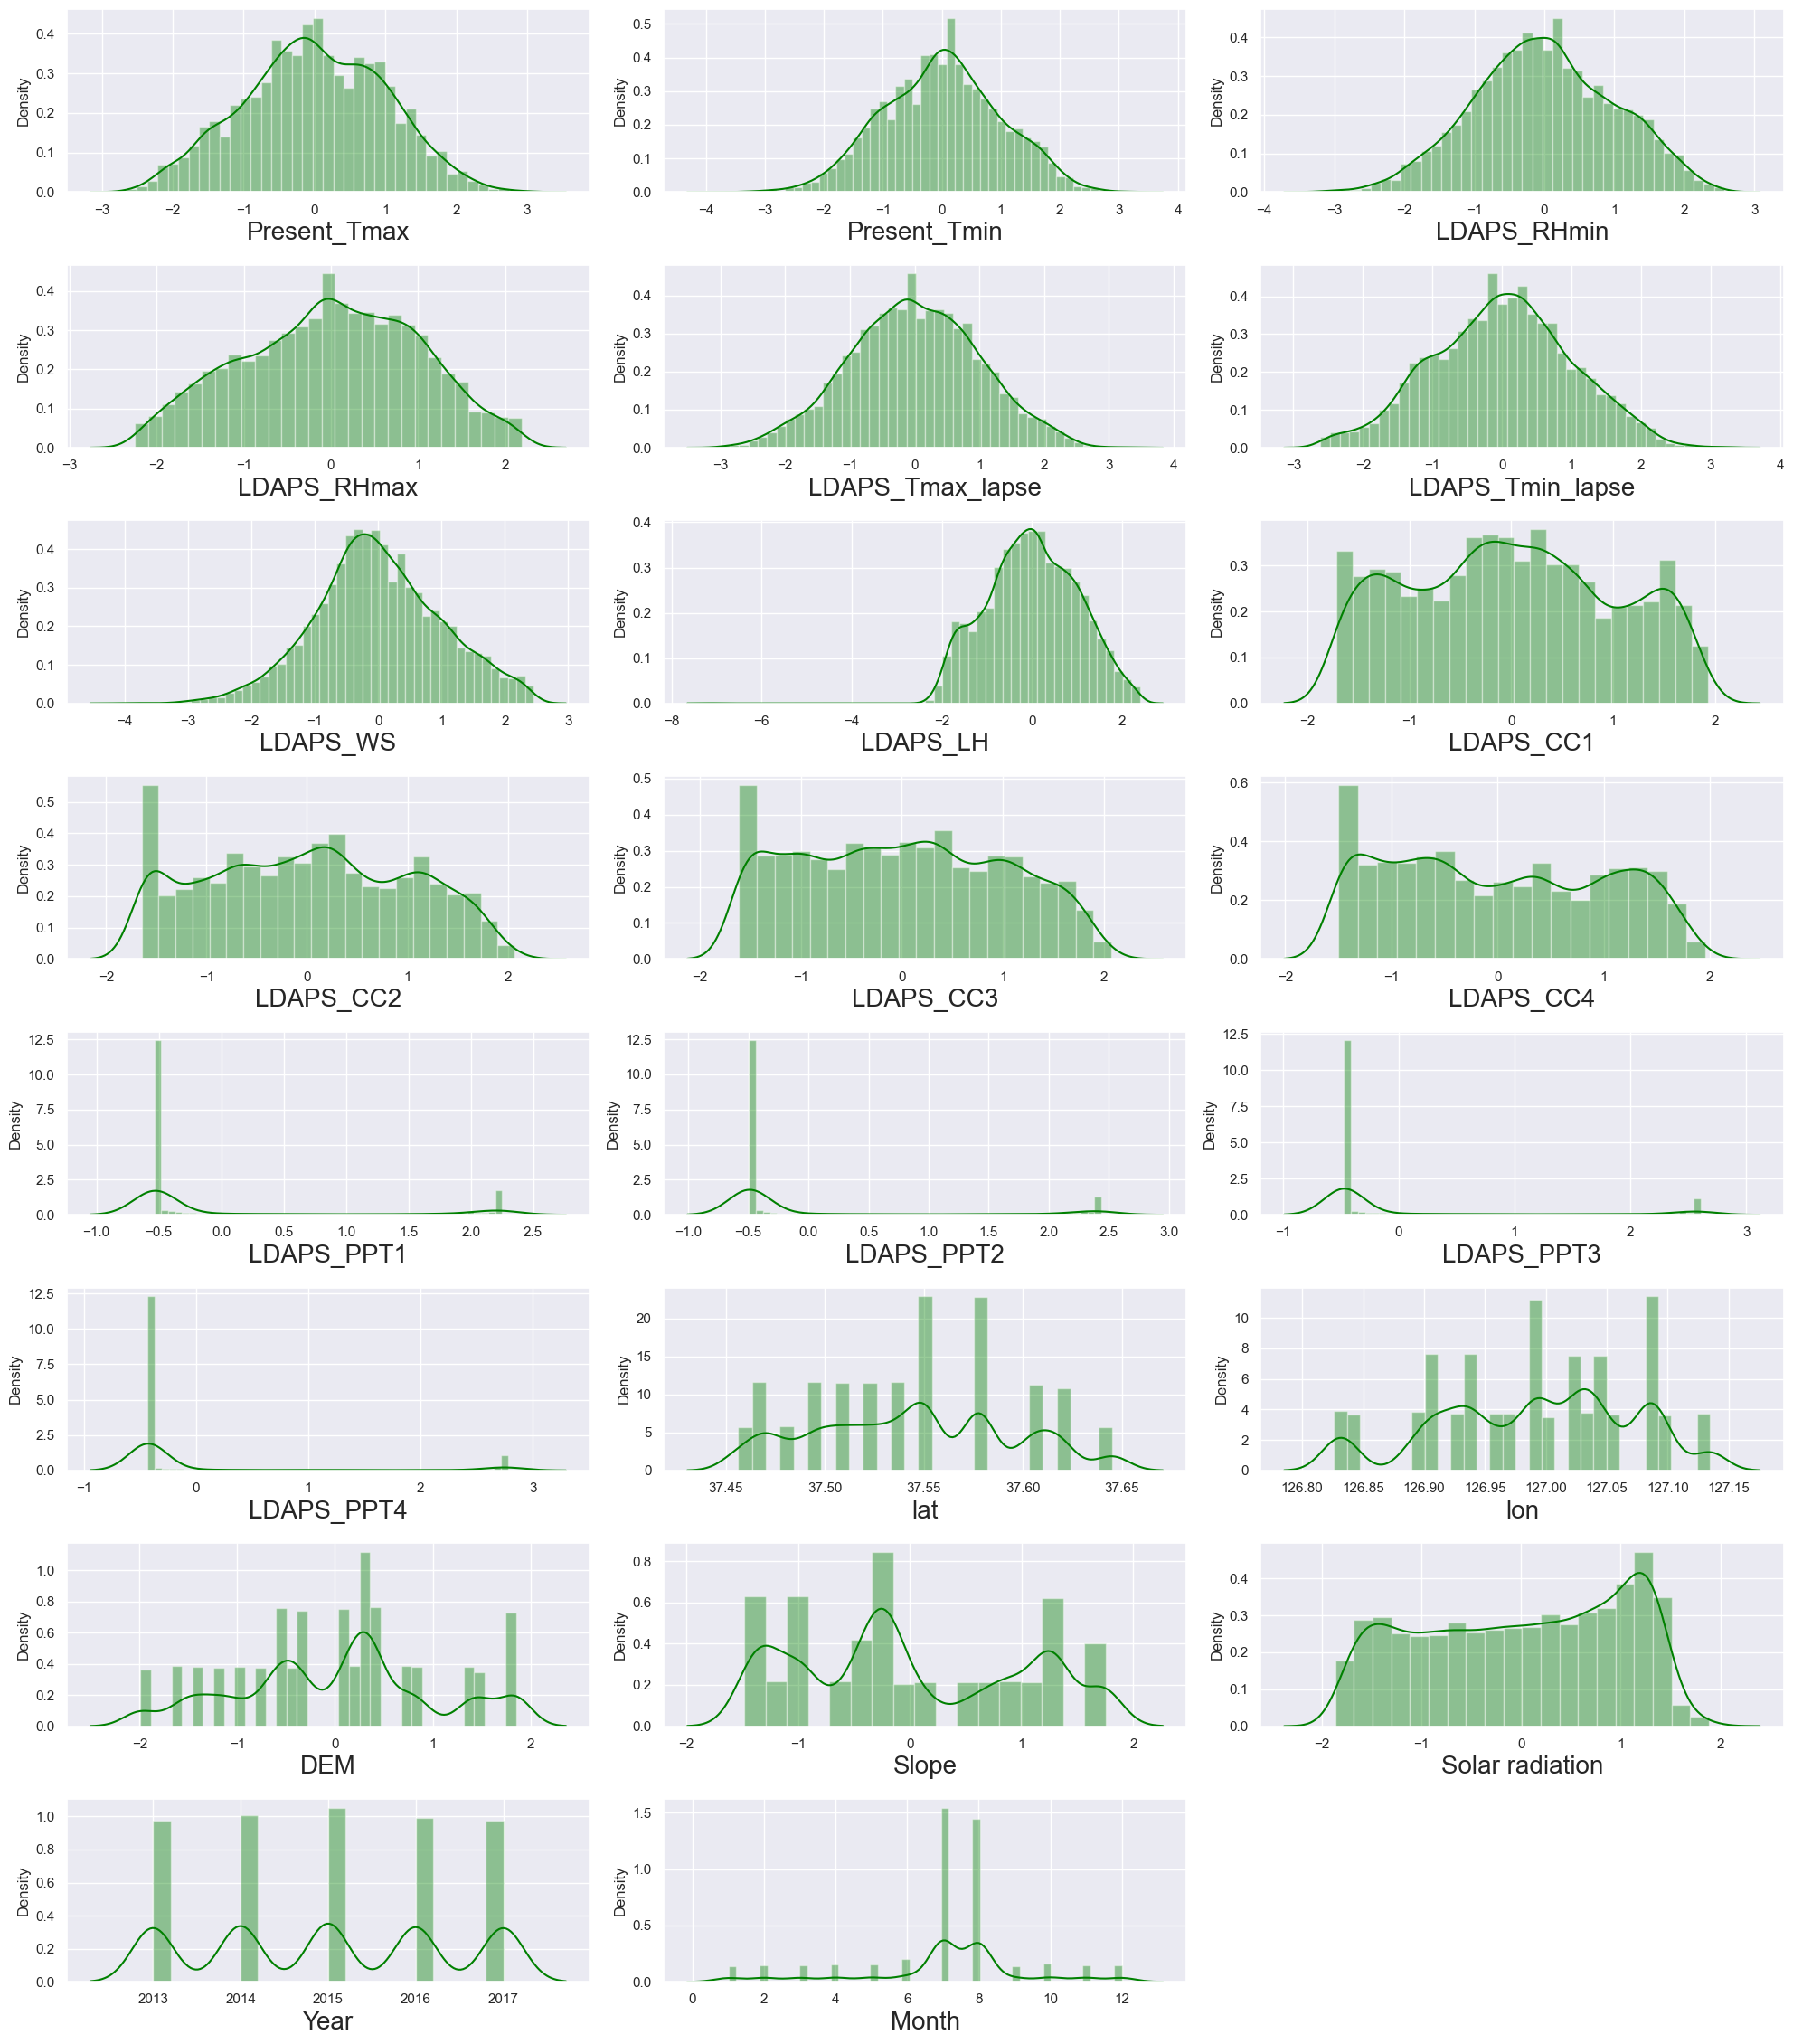

In [58]:
# Distribuição após a redução parcial da assimetria (skewness)
# Visualizamos como as variáveis estão distribuídas após a aplicação do PowerTransformer para verificar se a normalização dos dados foi eficaz

plt.figure(figsize=(20,25), facecolor="white")
plotnumber = 1

for column in x:
    if plotnumber <=25:
        ax = plt.subplot(9,3, plotnumber)
        sns.distplot(x[column], color="green")
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()



# Avaliando multicolinearidade


### ✅ **Para que serve o VIF em um projeto de Machine Learning:**

#### 1. **Identificar multicolinearidade**

* O VIF te ajuda a **detectar quando duas ou mais variáveis carregam informações redundantes**.
* Por exemplo: se você tem `Área em m²` e `Número de quartos`, pode haver uma correlação forte entre elas. O VIF vai te alertar sobre isso.

#### 2. **Evitar instabilidade em modelos lineares**

* Em **modelos baseados em regressão linear**, **SVM linear**, ou **logistic regression**, a presença de multicolinearidade pode:

  * **Aumentar a variância dos coeficientes** (ou pesos), tornando as previsões instáveis.
  * **Dificultar a interpretação dos pesos**, pois eles ficam distorcidos.
  * **Comprometer o desempenho do modelo**, especialmente em conjuntos de dados pequenos.

#### 3. **Melhorar interpretabilidade**

* Em modelos explicativos (ex: regressão linear), reduzir variáveis com VIF alto deixa o modelo **mais fácil de entender** e **mais confiável**.

---

### ⚠️ **Mas atenção: o VIF não é sempre necessário**

* Em **modelos baseados em árvore** como:

  * `Random Forest`
  * `XGBoost`
  * `LightGBM`
  * `Decision Trees`

  A multicolinearidade **não é um problema sério**. Esses modelos conseguem naturalmente lidar com variáveis correlacionadas.

---

### 🧠 Em resumo:

| Quando usar o VIF?                       | Para quê?                                          |
| ---------------------------------------- | -------------------------------------------------- |
| Modelos lineares (Regressão, SVM, GLM)   | Detectar e remover multicolinearidade              |
| Modelos interpretativos                  | Melhorar a clareza e estabilidade dos coeficientes |
| Árvores de decisão e ensembles (RF, XGB) | Não é necessário, o modelo já trata internamente   |



In [60]:
# Cálculo do Fator de Inflação da Variância (VIF) para cada coluna escalonada
# O VIF nos mostra o grau de multicolinearidade entre as variáveis independentes.
# Ele mede o quanto uma variável pode ser explicada linearmente pelas demais.
# Valores altos indicam forte correlação com outras variáveis, o que pode afetar a estabilidade do modelo.
# Podemos optar por remover variáveis com VIF muito alto para reduzir a multicolinearidade.
# Observamos que as colunas "LDAPS_Tmin_lapse" e "LDAPS_Tmax_lapse" apresentam alta multicolinearidade.

# Cálculo do Fator de Inflação da Variância (VIF) para as variáveis independentes
# Importa a função variance_inflation_factor da biblioteca statsmodels
# Cria um DataFrame chamado "vif" para armazenar os resultados
# Para cada coluna escalonada em x_scaled, calcula-se o VIF correspondente
# O VIF avalia a multicolinearidade entre as variáveis — ou seja, o quanto uma variável está linearmente correlacionada com as demais
# Valores de VIF > 5 ou 10 indicam forte multicolinearidade, e essas variáveis podem ser candidatas à remoção
# Por fim, associa os valores de VIF aos nomes das colunas originais em "x.columns"

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor( x_scaled, i) for i in range(x_scaled.shape[1])]
vif["Features"] = x.columns
vif

vif          Features
0   2.680478      Present_Tmax
1   3.089464      Present_Tmin
2   5.897446       LDAPS_RHmin
3   2.264759       LDAPS_RHmax
4   6.918601  LDAPS_Tmax_lapse
5   6.964233  LDAPS_Tmin_lapse
6   1.243175          LDAPS_WS
7   1.537009          LDAPS_LH
8   3.509706         LDAPS_CC1
9   4.743336         LDAPS_CC2
10  4.973296         LDAPS_CC3
11  2.733242         LDAPS_CC4
12  1.552349        LDAPS_PPT1
13  1.422845        LDAPS_PPT2
14  1.262337        LDAPS_PPT3
15  1.276863        LDAPS_PPT4
16  1.182878               lat
17  1.169968               lon
18  2.843147               DEM
19  2.799373             Slope
20  1.345956   Solar radiation
21  1.140061              Year
22  1.129258             Month

In [61]:
# As variáveis "LDAPS_Tmin_lapse" e "LDAPS_Tmax_lapse" foram removidas, pois ao eliminar ambas, o VIF total foi reduzido de forma mais significativa do que ao remover apenas uma delas.
# Isso ajuda a minimizar a multicolinearidade e melhorar a estabilidade do modelo.

# Padronização dos dados e cálculo do VIF (Fator de Inflação da Variância)

# Aplicamos o StandardScaler para padronizar as variáveis independentes (x),
# transformando os dados para que tenham média 0 e desvio padrão 1,
# o que é necessário antes de calcular o VIF.

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Importamos a função variance_inflation_factor para calcular o VIF de cada variável.
# O VIF mede o quanto uma variável está linearmente correlacionada com as outras,
# sendo uma métrica importante para detectar multicolinearidade.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()

# Para cada coluna escalonada, calculamos o VIF correspondente.
vif["vif"] = [variance_inflation_factor(x_scaled, i) for i in range(x_scaled.shape[1])]

# Atribuímos os nomes das variáveis originais à coluna "Features" para facilitar a leitura.
vif["Features"] = x.columns

# Exibimos a tabela de VIFs para análise
vif


vif          Features
0   2.790155      Present_Tmax
1   3.101998      Present_Tmin
2   5.594533       LDAPS_RHmin
3   2.509910       LDAPS_RHmax
4   6.458489  LDAPS_Tmax_lapse
5   6.905975  LDAPS_Tmin_lapse
6   1.201821          LDAPS_WS
7   1.500057          LDAPS_LH
8   4.298950         LDAPS_CC1
9   5.145675         LDAPS_CC2
10  4.603571         LDAPS_CC3
11  2.799990         LDAPS_CC4
12  2.277956        LDAPS_PPT1
13  1.971918        LDAPS_PPT2
14  1.685741        LDAPS_PPT3
15  1.649826        LDAPS_PPT4
16  1.219968               lat
17  1.222734               lon
18  2.829004               DEM
19  2.686421             Slope
20  1.325860   Solar radiation
21  1.124916              Year
22  1.124361             Month

In [62]:
def visualizar_vif(vif_df, limite_alerta=10):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Ordenar do maior para o menor VIF
    vif_df_sorted = vif_df.sort_values("vif", ascending=False)

    # Criar gráfico
    plt.figure(figsize=(10, max(6, len(vif_df_sorted) * 0.25)))
    sns.barplot(data=vif_df_sorted, x="vif", y="Features", palette="viridis")

    # Linha de corte para VIF alto
    plt.axvline(limite_alerta, color='red', linestyle='--', label=f'Limite = {limite_alerta}')
    plt.title("Fator de Inflação da Variância (VIF) por Variável")
    plt.xlabel("VIF")
    plt.ylabel("Variável")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_29332\2150777315.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_df_sorted, x="vif", y="Features", palette="viridis")


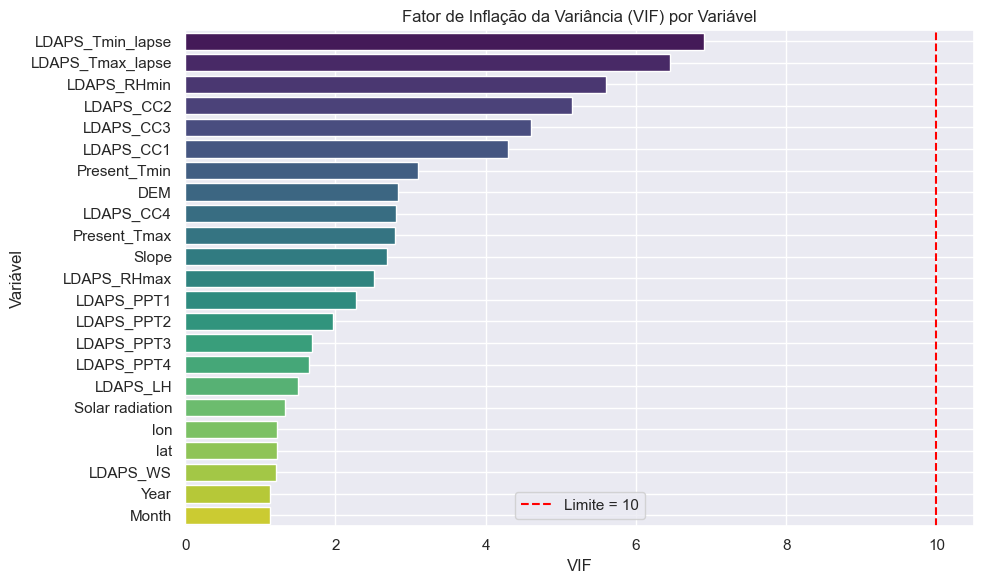

In [63]:
visualizar_vif(vif)

Variance Inflation Factor
- Interpretação rápida do gráfico:
- VIF ≈ 1: Sem multicolinearidade.
- VIF > 5: Suspeita de multicolinearidade.
- VIF > 10: Forte multicolinearidade (avaliar remoção da variável).

---

# Separando dados em Treino e Teste

In [64]:
# Divisão do conjunto de dados em treino e teste
# Escolhemos o random_state = 200 para garantir reprodutibilidade dos resultados
# 30% dos dados foram reservados para o conjunto de teste, e 70% para o conjunto de treino

# Dividindo os dados em conjuntos de treino e teste
# Utiliza a função train_test_split da biblioteca sklearn
# x_scaled: variáveis independentes já padronizadas
# y: variáveis-alvo (Next_Tmax e Next_Tmin)
# test_size=0.30 indica que 30% dos dados serão usados para teste e 70% para treino
# random_state=200 garante que a divisão seja reproduzível em execuções futuras

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.30, random_state = 200)

In [65]:
def plot_feature_importance(model, x_train, titulo="Importância das Variáveis"):
    # Se x_train for ndarray, dar nomes fictícios
    if not isinstance(x_train, pd.DataFrame):
        x_train = pd.DataFrame(x_train, columns=[f"Var_{i}" for i in range(x_train.shape[1])])

    importances = model.feature_importances_
    features = x_train.columns

    # Criar DataFrame para ordenar
    imp_df = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Plotar
    plt.figure(figsize=(10, 6))
    sns.barplot(data=imp_df, x="Importance", y="Feature", palette="viridis")
    plt.title(titulo)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [66]:
# Para colocar os nomes das colunas na matriz. Ficar entendível no gráfico de feature importance
x.columns
x_train_plot = pd.DataFrame(x_scaled, columns=x.columns)

# Treinando os modelos

- Criação de modelos de regressão com saída múltipla (MultiOutput)
- Neste cenário, estamos prevendo duas variáveis-alvo simultaneamente: "Next_Tmax" e "Next_Tmin"
- Para isso, utilizamos a estratégia MultiOutputRegressor que adapta modelos de regressão comuns para múltiplas saídas
- Foram considerados 4 algoritmos de aprendizado de máquina (ML) neste experimento

In [67]:
# Inicializar DataFrame para guardar os resultados
df_score = pd.DataFrame(columns=["id", "Fase","Modelo", "R2 Ajustado", "MAE", "MSE", "RMSE","tempo(s)"])
df_score.head()

Empty DataFrame
Columns: [id, Fase, Modelo, R2 Ajustado, MAE, MSE, RMSE, tempo(s)]
Index: []

### 1) DecisionTreeRegressor

In [68]:
from sklearn.tree import DecisionTreeRegressor

# Marcar o tempo inicial
inicio = time()
dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train,y_train)

y_pred = dt_reg.predict(x_test)

# Cálculo das métricas
r2 = dt_reg.score(x_train, y_train)
#r2a = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [1,"Inicial","DecisionTreeRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)

id     Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1  Inicial  DecisionTreeRegressor          1.0  1.024324  2.001631   

      RMSE  tempo(s)  
0  1.41479     0.094

C:\Users\User\AppData\Local\Temp\ipykernel_29332\2938484468.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importance", y="Feature", palette="viridis")


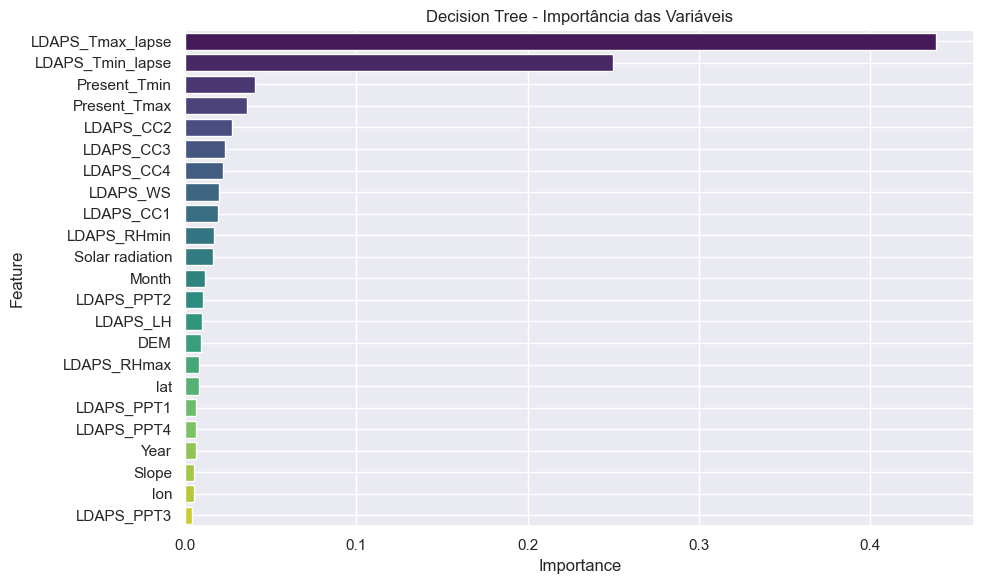

In [69]:
plot_feature_importance(dt_reg, x_train_plot, "Decision Tree - Importância das Variáveis")

---

### 2) RandomForestRegressor

In [70]:
from sklearn.ensemble import RandomForestRegressor
# Marcar o tempo inicial
inicio = time()

rf_reg = RandomForestRegressor()
rf_reg.fit(x_train,y_train)

y_pred = rf_reg.predict(x_test)

# Cálculo das métricas
r2 = rf_reg.score(x_train, y_train)
#r2a = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [2,"Inicial","RandomForestRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)





id     Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1  Inicial  DecisionTreeRegressor     1.000000  1.024324  2.001631   
1   2  Inicial  RandomForestRegressor     0.983955  0.680080  0.840752   

       RMSE  tempo(s)  
0  1.414790     0.094  
1  0.916925     6.006

C:\Users\User\AppData\Local\Temp\ipykernel_29332\2938484468.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importance", y="Feature", palette="viridis")


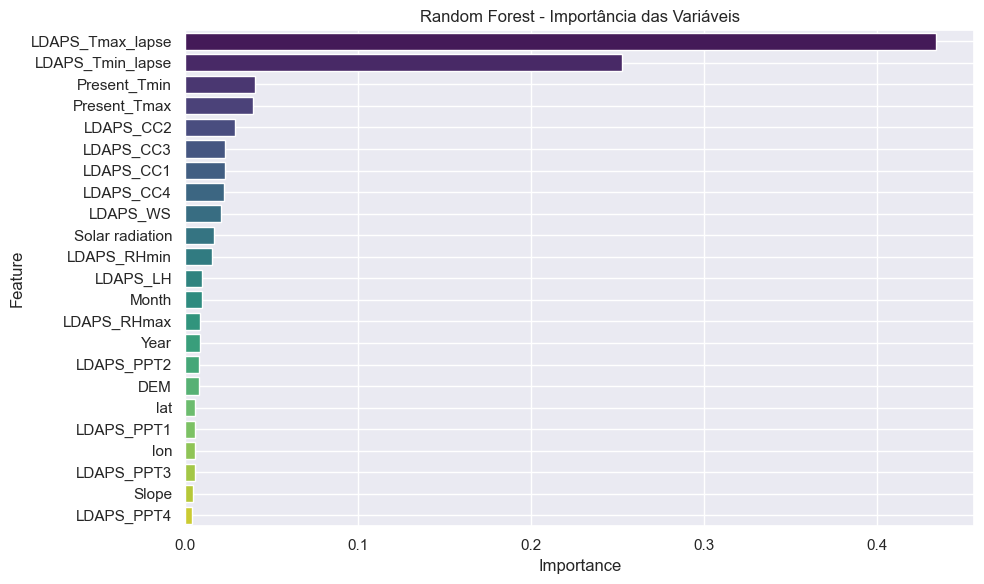

In [71]:
plot_feature_importance(rf_reg, x_train_plot, "Random Forest - Importância das Variáveis")


---

### 3) KNeighborsRegressor

In [72]:
from sklearn.neighbors import KNeighborsRegressor
# Marcar o tempo inicial
inicio = time()

k_neigh = KNeighborsRegressor()
k_neigh.fit(x_train,y_train)

y_pred = k_neigh.predict(x_test)


# Cálculo das métricas
r2 = k_neigh.score(x_train, y_train)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [3,"Inicial","KNeighborsRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)


id     Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1  Inicial  DecisionTreeRegressor     1.000000  1.024324  2.001631   
1   2  Inicial  RandomForestRegressor     0.983955  0.680080  0.840752   
2   3  Inicial    KNeighborsRegressor     0.914551  0.706540  0.893315   

       RMSE  tempo(s)  
0  1.414790     0.094  
1  0.916925     6.006  
2  0.945154     1.753

In [73]:
# plot_feature_importance(k_neigh, x_train_plot, "KNeighborsRegressor - Importância das Variáveis")
# Não possui 

---

### 4) ExtraTreesRegressor

In [74]:
from sklearn.ensemble import ExtraTreesRegressor
# Marcar o tempo inicial
inicio = time()
ext_reg = ExtraTreesRegressor()
ext_reg.fit(x_train,y_train)

y_pred = ext_reg.predict(x_test)

# Cálculo das métricas
r2 = ext_reg.score(x_train, y_train)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [4,"Inicial","ExtraTreesRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)


id     Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1  Inicial  DecisionTreeRegressor     1.000000  1.024324  2.001631   
1   2  Inicial  RandomForestRegressor     0.983955  0.680080  0.840752   
2   3  Inicial    KNeighborsRegressor     0.914551  0.706540  0.893315   
3   4  Inicial    ExtraTreesRegressor     1.000000  0.586135  0.618245   

       RMSE  tempo(s)  
0  1.414790     0.094  
1  0.916925     6.006  
2  0.945154     1.753  
3  0.786286     2.448

C:\Users\User\AppData\Local\Temp\ipykernel_29332\2938484468.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importance", y="Feature", palette="viridis")


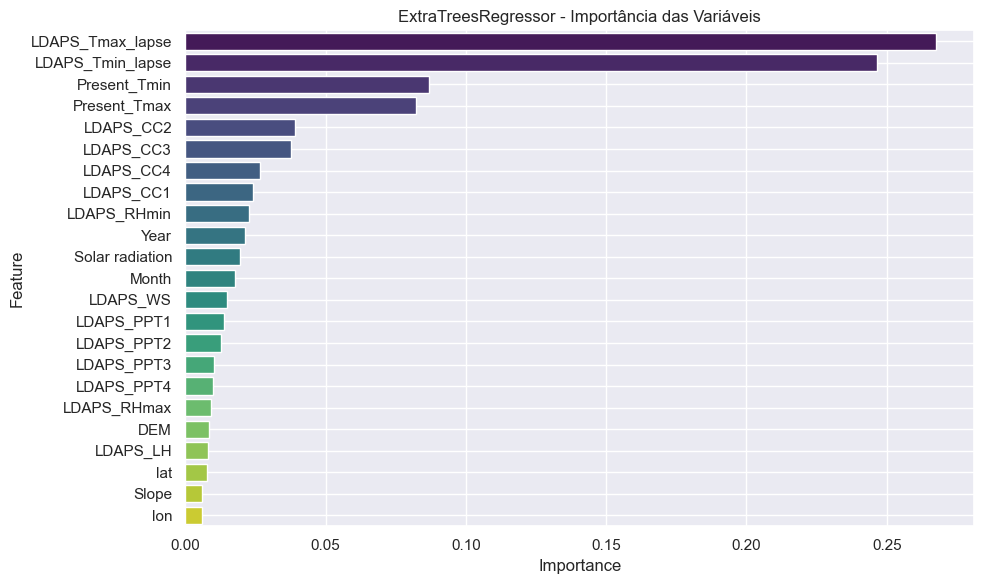

In [75]:
plot_feature_importance(ext_reg, x_train_plot, "ExtraTreesRegressor - Importância das Variáveis")

---

# Avaliação dos modelos

In [77]:
# Arredonda os valores e ordena pela métrica desejada (ex: RMSE)
df_score_rounded = df_score.copy()
df_score_rounded.iloc[:, 1:] = df_score_rounded.iloc[:, 1:].round(3)
df_score_rounded = df_score_rounded.sort_values(by="RMSE").reset_index(drop=True)

# Aplica estilo para destacar os melhores resultados
styled_df = df_score_rounded.style\
    .highlight_min(axis=0, color='lightgreen', subset=["MAE", "RMSE"])\
    .highlight_max(axis=0, color='salmon', subset=["R2 Ajustado"])\
    .set_caption("Comparação de Desempenho dos Modelos")\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

styled_df


---

# Validação Cruzada
- Validação cruzada para verificar se o modelo está sofrendo overfitting
- A validação cruzada (cross-validation) divide o conjunto de dados em múltiplas partes (folds),
- treinando o modelo em algumas e testando em outras, repetidamente.
- Isso permite avaliar se o modelo está generalizando bem ou apenas memorizando os dados de treino.
- Métricas muito altas no treino e baixas na validação indicam possível overfitting.


In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


In [79]:
def print_cross_validation_scheme(n_folds=5):
    print("\n📊 Esquema da Validação Cruzada:\n")
    for i in range(n_folds):
        row = []
        for j in range(n_folds):
            if j == i:
                row.append("TEST ")
            else:
                row.append("TRAIN")
        print(f"Fold {i+1}:  [{ ' | '.join(row) }]")


In [80]:
# Exibe a estrutura dos folds
print_cross_validation_scheme(n_folds=5)


📊 Esquema da Validação Cruzada:

Fold 1:  [TEST  | TRAIN | TRAIN | TRAIN | TRAIN]
Fold 2:  [TRAIN | TEST  | TRAIN | TRAIN | TRAIN]
Fold 3:  [TRAIN | TRAIN | TEST  | TRAIN | TRAIN]
Fold 4:  [TRAIN | TRAIN | TRAIN | TEST  | TRAIN]
Fold 5:  [TRAIN | TRAIN | TRAIN | TRAIN | TEST ]


### 1) DecisionTreeRegressor

In [81]:
# Cross-validation
# Marcar o tempo inicial
inicio = time()
scoring = {
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

results = cross_validate(dt_reg, x, y, cv=5, scoring=scoring, return_train_score=False)

# Convertendo os valores negativos (porque o sklearn retorna erros negativos para otimização)
mae = -results['test_neg_mean_absolute_error'].mean()
mse = -results['test_neg_mean_squared_error'].mean()
rmse = -results['test_neg_root_mean_squared_error'].mean()
r2 = results['test_r2'].mean()

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [1,"cross_validate","DecisionTreeRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)



id            Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1         Inicial  DecisionTreeRegressor     1.000000  1.024324  2.001631   
1   2         Inicial  RandomForestRegressor     0.983955  0.680080  0.840752   
2   3         Inicial    KNeighborsRegressor     0.914551  0.706540  0.893315   
3   4         Inicial    ExtraTreesRegressor     1.000000  0.586135  0.618245   
4   1  cross_validate  DecisionTreeRegressor     0.426035  1.496652  3.790681   

       RMSE  tempo(s)  
0  1.414790     0.094  
1  0.916925     6.006  
2  0.945154     1.753  
3  0.786286     2.448  
4  1.915433     0.578

In [82]:
# Inicializar KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Criar DataFrame para armazenar os resultados
df_folds = pd.DataFrame(columns=["Fold", "R2", "MAE", "MSE", "RMSE"])

# Loop pelos folds
for i, (train_index, test_index) in enumerate(kf.split(x)):
    x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Treinar modelo
    dt_reg.fit(x_train_fold, y_train_fold)
    y_pred_fold = dt_reg.predict(x_test_fold)

    # Calcular métricas
    r2 = r2_score(y_test_fold, y_pred_fold)
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    mse = mean_squared_error(y_test_fold, y_pred_fold)
    rmse = np.sqrt(mse)

    # Armazenar
    df_folds.loc[i] = [f"Fold {i+1}", round(r2, 3), round(mae, 3), round(mse, 3), round(rmse, 3)]

# Adicionar linha com médias finais
df_folds.loc["Média"] = ["Média",
    df_folds["R2"].astype(float).mean().round(3),
    df_folds["MAE"].astype(float).mean().round(3),
    df_folds["MSE"].astype(float).mean().round(3),
    df_folds["RMSE"].astype(float).mean().round(3)
]

# Exibir a tabela
import pandas.io.formats.style
df_folds.style.set_caption("Resultados por Fold - DecisionTreeRegressor").format(precision=3)


### 2) RandomForestRegressor

In [83]:
# Marcar o tempo inicial
inicio = time()
# Cross-validation
scoring = {
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

results = cross_validate(rf_reg, x, y, cv=5, scoring=scoring, return_train_score=False)

# Convertendo os valores negativos (porque o sklearn retorna erros negativos para otimização)
mae = -results['test_neg_mean_absolute_error'].mean()
mse = -results['test_neg_mean_squared_error'].mean()
rmse = -results['test_neg_root_mean_squared_error'].mean()
r2 = results['test_r2'].mean()

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [2,"cross_validate","RandomForestRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)


id            Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1         Inicial  DecisionTreeRegressor     1.000000  1.024324  2.001631   
1   2         Inicial  RandomForestRegressor     0.983955  0.680080  0.840752   
2   3         Inicial    KNeighborsRegressor     0.914551  0.706540  0.893315   
3   4         Inicial    ExtraTreesRegressor     1.000000  0.586135  0.618245   
4   1  cross_validate  DecisionTreeRegressor     0.426035  1.496652  3.790681   
5   2  cross_validate  RandomForestRegressor     0.701169  1.073297  2.010255   

       RMSE  tempo(s)  
0  1.414790     0.094  
1  0.916925     6.006  
2  0.945154     1.753  
3  0.786286     2.448  
4  1.915433     0.578  
5  1.384963    34.345

### 3) KNeighborsRegressor

In [84]:
# Marcar o tempo inicial
inicio = time()
# Cross-validation
scoring = {
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

results = cross_validate(k_neigh, x, y, cv=5, scoring=scoring, return_train_score=False)

# Convertendo os valores negativos (porque o sklearn retorna erros negativos para otimização)
mae = -results['test_neg_mean_absolute_error'].mean()
mse = -results['test_neg_mean_squared_error'].mean()
rmse = -results['test_neg_root_mean_squared_error'].mean()
r2 = results['test_r2'].mean()

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [3,"cross_validate","KNeighborsRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)

id            Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1         Inicial  DecisionTreeRegressor     1.000000  1.024324  2.001631   
1   2         Inicial  RandomForestRegressor     0.983955  0.680080  0.840752   
2   3         Inicial    KNeighborsRegressor     0.914551  0.706540  0.893315   
3   4         Inicial    ExtraTreesRegressor     1.000000  0.586135  0.618245   
4   1  cross_validate  DecisionTreeRegressor     0.426035  1.496652  3.790681   
5   2  cross_validate  RandomForestRegressor     0.701169  1.073297  2.010255   
6   3  cross_validate    KNeighborsRegressor     0.462276  1.445273  3.533085   

       RMSE  tempo(s)  
0  1.414790     0.094  
1  0.916925     6.006  
2  0.945154     1.753  
3  0.786286     2.448  
4  1.915433     0.578  
5  1.384963    34.345  
6  1.854604     0.081

### 4) ExtraTreesRegressor

In [85]:
# Marcar o tempo inicial
inicio = time()
# Cross-validation
scoring = {
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

results = cross_validate(ext_reg, x, y, cv=5, scoring=scoring, return_train_score=False)

# Convertendo os valores negativos (porque o sklearn retorna erros negativos para otimização)
mae = -results['test_neg_mean_absolute_error'].mean()
mse = -results['test_neg_mean_squared_error'].mean()
rmse = -results['test_neg_root_mean_squared_error'].mean()
r2 = results['test_r2'].mean()

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

# Armazenar no DataFrame
df_score.loc[len(df_score)] = [4,"cross_validate","ExtraTreesRegressor", r2, mae, mse, rmse,duracao]

df_score.head(20)

id            Fase                 Modelo  R2 Ajustado       MAE       MSE  \
0   1         Inicial  DecisionTreeRegressor     1.000000  1.024324  2.001631   
1   2         Inicial  RandomForestRegressor     0.983955  0.680080  0.840752   
2   3         Inicial    KNeighborsRegressor     0.914551  0.706540  0.893315   
3   4         Inicial    ExtraTreesRegressor     1.000000  0.586135  0.618245   
4   1  cross_validate  DecisionTreeRegressor     0.426035  1.496652  3.790681   
5   2  cross_validate  RandomForestRegressor     0.701169  1.073297  2.010255   
6   3  cross_validate    KNeighborsRegressor     0.462276  1.445273  3.533085   
7   4  cross_validate    ExtraTreesRegressor     0.703594  1.065560  2.019402   

       RMSE  tempo(s)  
0  1.414790     0.094  
1  0.916925     6.006  
2  0.945154     1.753  
3  0.786286     2.448  
4  1.915433     0.578  
5  1.384963    34.345  
6  1.854604     0.081  
7  1.382160    13.255

In [86]:
df_score_rounded = df_score.copy()
df_score_rounded.iloc[:, 1:] = df_score_rounded.iloc[:, 1:].round(3)
df_score_rounded.sort_values(by="RMSE")  # ou qualquer outra métrica de ordenação


id            Fase                 Modelo  R2 Ajustado    MAE    MSE  \
3   4         Inicial    ExtraTreesRegressor        1.000  0.586  0.618   
1   2         Inicial  RandomForestRegressor        0.984  0.680  0.841   
2   3         Inicial    KNeighborsRegressor        0.915  0.707  0.893   
7   4  cross_validate    ExtraTreesRegressor        0.704  1.066  2.019   
5   2  cross_validate  RandomForestRegressor        0.701  1.073  2.010   
0   1         Inicial  DecisionTreeRegressor        1.000  1.024  2.002   
6   3  cross_validate    KNeighborsRegressor        0.462  1.445  3.533   
4   1  cross_validate  DecisionTreeRegressor        0.426  1.497  3.791   

    RMSE  tempo(s)  
3  0.786     2.448  
1  0.917     6.006  
2  0.945     1.753  
7  1.382    13.255  
5  1.385    34.345  
0  1.415     0.094  
6  1.855     0.081  
4  1.915     0.578

# 🧪 Comparativo dos resultados:

In [87]:
# Filtrar os dados por fase
df_inicial = df_score[df_score["Fase"] == "Inicial"][["Modelo", "R2 Ajustado"]].rename(columns={"R2 Ajustado": "R2 Ajustado (Inicial)"})
df_cv = df_score[df_score["Fase"] == "cross_validate"][["Modelo", "R2 Ajustado"]].rename(columns={"R2 Ajustado": "R2 Ajustado (cross_validate)"})

# Juntar os dois DataFrames pela coluna 'Modelo'
df_results = pd.merge(df_inicial, df_cv, on="Modelo")

# Calcular a diferença
df_results["Diferença"] = df_results["R2 Ajustado (Inicial)"] - df_results["R2 Ajustado (cross_validate)"]

# Ordenar pelo menor valor da coluna 'Diferença'
df_results = df_results.sort_values(by="Diferença", ascending=True).reset_index(drop=True)

# Adicionar coluna de destaque com ícone
df_results["✓ Melhor"] = ["✅" if i == 0 else "❌" for i in df_results.index]

# Exibir resultado
df_results.head()


Modelo  R2 Ajustado (Inicial)  R2 Ajustado (cross_validate)  \
0  RandomForestRegressor               0.983955                      0.701169   
1    ExtraTreesRegressor               1.000000                      0.703594   
2    KNeighborsRegressor               0.914551                      0.462276   
3  DecisionTreeRegressor               1.000000                      0.426035   

   Diferença ✓ Melhor  
0   0.282786        ✅  
1   0.296406        ❌  
2   0.452276        ❌  
3   0.573965        ❌

- Seleção do melhor modelo de machine learning para este conjunto de dados
- Com base nos algoritmos avaliados, o modelo RandomForestRegressor demonstrou o melhor desempenho.
- Comparado aos demais, ele apresentou a menor diferença entre a acurácia no treino (R² ajustado) e a validação cruzada, indicando melhor capacidade de generalização.
- Os 4 algoritmos testados suportam regressão com múltiplas saídas (multioutput), ao contrário de outros modelos tradicionais.
- A técnica utilizada foi o MultiOutputRegressor, que consiste em treinar um regressor separado para cada variável-alvo.
- Essa é uma estratégia simples e eficaz para estender modelos de regressão que não suportam nativamente múltiplas saídas.

🎯 Treina modelos e mede o R² no treino (ou split fixo) — R²_inicial.

Executa validação cruzada e mede R²_cv.

Calcula a diferença ΔR² = R²_inicial - R²_cv.

Classifica os modelos pela menor diferença (ΔR² menor → mais estável/generalizável).

✅ Por que isso tem lógica:
Um modelo com R² muito alto no treino, mas muito mais baixo na validação cruzada, provavelmente está superajustado (overfitting).

Um modelo com R² semelhante em treino e validação tende a ser mais estável e generalizável.



# 🧠 Treinamento do modelo RandomForest

In [88]:
# Importação do MultiOutputRegressor da biblioteca sklearn
# Esta classe permite aplicar algoritmos de regressão tradicionais em problemas com múltiplas variáveis-alvo (multioutput)
# A estratégia consiste em treinar um regressor independente para cada coluna do target (y),
# tornando possível utilizar modelos que não suportam múltiplas saídas nativamente

from sklearn.multioutput import MultiOutputRegressor

In [89]:
# Criação do modelo de regressão com múltiplas saídas (multioutput) utilizando RandomForestRegressor como estimador base
# O MultiOutputRegressor irá treinar um modelo RandomForest separado para cada variável-alvo (Next_Tmax e Next_Tmin)
# Isso permite realizar previsões conjuntas para múltiplos alvos, mesmo que o RandomForest não suporte isso nativamente

multiregressor = MultiOutputRegressor(rf_reg)

In [90]:
# Marcar o tempo inicial
inicio = time()
# 🚀 Treinamento do modelo multialvo
# Aqui, o MultiOutputRegressor ajusta (fit) um modelo RandomForest individual para cada variável-alvo (Next_Tmax e Next_Tmin)
# Utiliza os dados de treino (x_train e y_train) previamente escalonados e preparados

multiregressor.fit(x_train,y_train)

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

print(f"Tempo de execução: {duracao} segundos")

Tempo de execução: 12.178 segundos


In [91]:
# 🧱 Instanciação do MultiOutputRegressor com RandomForestRegressor como estimador base
# Essa estrutura permite aplicar RandomForest para problemas com múltiplas variáveis-alvo,
# criando um modelo separado de RandomForest para cada coluna de saída
MultiOutputRegressor(estimator=RandomForestRegressor())


MultiOutputRegressor(estimator=RandomForestRegressor())

In [92]:
# 📊 Avaliação do desempenho do modelo multialvo nos dados de treino
# O método .score() retorna, por padrão, o coeficiente de determinação R² médio entre os modelos internos
# Quanto mais próximo de 1, melhor o ajuste do modelo aos dados de treino
multiregressor.score(x_train, y_train)


0.9847185887976966

- 🔧 Otimização de Hiperparâmetros (Hyperparameter Tuning)
- Vamos tentar ajustar o modelo proposto (RandomForestRegressor) para melhorar a acurácia, se possível.
- Os "parâmetros" utilizados foram selecionados com base na documentação da biblioteca scikit-learn.
- Neste experimento, foram considerados 4 hiperparâmetros principais para o ajuste:
    - criterion
    - max_features
    - oob_score
    - random_state


In [93]:
parameters = {
    "criterion": ["squared_error", "absolute_error"],  
    "max_features": ["sqrt", "log2"],                  
    "oob_score": [True, False],
    "random_state": [30, 50, 70, 100, 120]
}

- 🎯 Uso do RandomizedSearchCV para ajuste de hiperparâmetros
- Utilizamos o RandomizedSearchCV para encontrar a melhor combinação de hiperparâmetros aplicando o ajuste diretamente sobre o conjunto de dados de treino.
- Essa abordagem foi escolhida por ser mais eficiente do que o GridSearchCV, especialmente em conjuntos de dados grandes, onde o processamento completo seria muito custoso.
- Limitamos o número de iterações em 10 para obter os melhores parâmetros de forma mais rápida e econômica.


In [94]:
# Marcar o tempo inicial
inicio = time()
# 🔍 Definindo o RandomizedSearchCV para ajuste dos hiperparâmetros do RandomForestRegressor
# - Utiliza validação cruzada com 5 divisões (cv=5) para avaliar a performance em diferentes subconjuntos de dados
# - "parameters" é o dicionário contendo os hiperparâmetros e seus possíveis valores
# - "n_iter=10" define que 10 combinações aleatórias serão testadas a partir do espaço de parâmetros
# Isso permite encontrar uma boa configuração de forma mais rápida do que testar todas as combinações possíveis (como no GridSearchCV)

from sklearn.model_selection import RandomizedSearchCV
RCV = RandomizedSearchCV(RandomForestRegressor(), parameters, cv=5, n_iter=10)
# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

print(f"Tempo de execução: {duracao} segundos")

Tempo de execução: 0.0 segundos


In [95]:
# Marcar o tempo inicial
inicio = time()
# 🚀 Ajuste (fit) do RandomizedSearchCV aos dados de treino
# Aqui o RandomizedSearchCV treina múltimos modelos RandomForest com diferentes combinações de hiperparâmetros
# Utiliza validação cruzada (cv=5) para avaliar cada combinação
# Ao final, seleciona automaticamente o modelo com o melhor desempenho nos folds de validação
RCV.fit(x_train, y_train)

# Marcar o tempo final
fim = time()

# Calcular a duração
duracao = round(fim - inicio, 3)

print(f"Tempo de execução: {duracao} segundos")


Tempo de execução: 748.532 segundos


In [96]:
# 🧪 Configuração do RandomizedSearchCV para ajuste de hiperparâmetros do RandomForestRegressor
# - cv=5: utiliza validação cruzada com 5 subdivisões
# - estimator=RandomForestRegressor(): define o modelo base a ser ajustado
# - param_distributions: dicionário com os hiperparâmetros e valores possíveis a serem testados
#   • 'criterion': função de avaliação da qualidade da divisão (mse ou mae)
#   • 'max_features': número de features consideradas em cada divisão (auto, sqrt ou log2)
#   • 'oob_score': se deve usar a amostragem fora da amostra (Out-Of-Bag) como validação
#   • 'random_state': diferentes sementes para reprodutibilidade e variação dos resultados
# O RandomizedSearchCV irá sortear aleatoriamente combinações desses parâmetros e testar o desempenho de cada uma.

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'oob_score': [True, False],
                                        'random_state': [30, 50, 70, 100, 120]})

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'oob_score': [True, False],
                                        'random_state': [30, 50, 70, 100, 120]})

In [97]:
# 🏆 Exibe os melhores hiperparâmetros encontrados pelo RandomizedSearchCV
# Após o treinamento, essa propriedade retorna o dicionário com a melhor combinação de parâmetros
# que obteve o melhor desempenho durante a validação cruzada
RCV.best_params_


{'random_state': 120,
 'oob_score': True,
 'max_features': 'sqrt',
 'criterion': 'squared_error'}

In [98]:
# ✅ Armazena o melhor modelo ajustado com os hiperparâmetros ideais encontrados pelo RandomizedSearchCV
# O best_estimator_ retorna o modelo RandomForestRegressor já treinado com a melhor combinação de parâmetros
# Esse modelo pode ser usado diretamente para previsões ou avaliação final
mod_final = RCV.best_estimator_


### Visualização da arvore de decisões

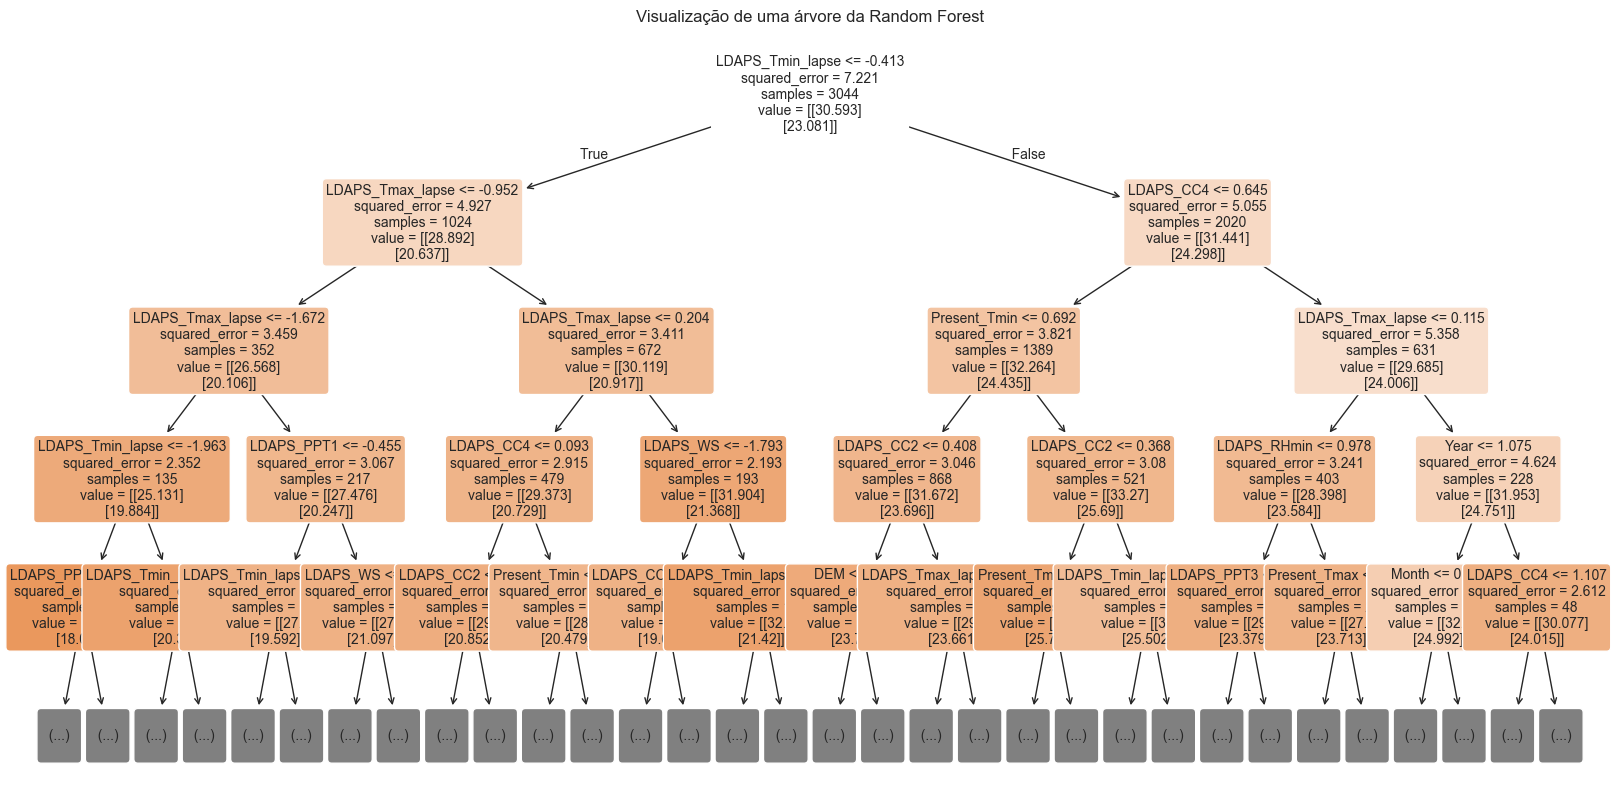

In [99]:


# Acessar o melhor modelo ajustado do RandomizedSearchCV
best_rf = RCV.best_estimator_

# Selecionar uma das árvores (ex: primeira)
estimator = best_rf.estimators_[0]

# Usar os nomes das colunas do DataFrame original
feature_names = x.columns  # x deve ser o DataFrame antes de aplicar o scaler

# Plotar a árvore
plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          max_depth=4,       # limita a profundidade para facilitar leitura
          fontsize=10)
plt.title("Visualização de uma árvore da Random Forest")
plt.show()



### Verificando as variáveis mais importantes

C:\Users\User\AppData\Local\Temp\ipykernel_29332\1168525244.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x="Importance", y="Feature", palette="viridis")


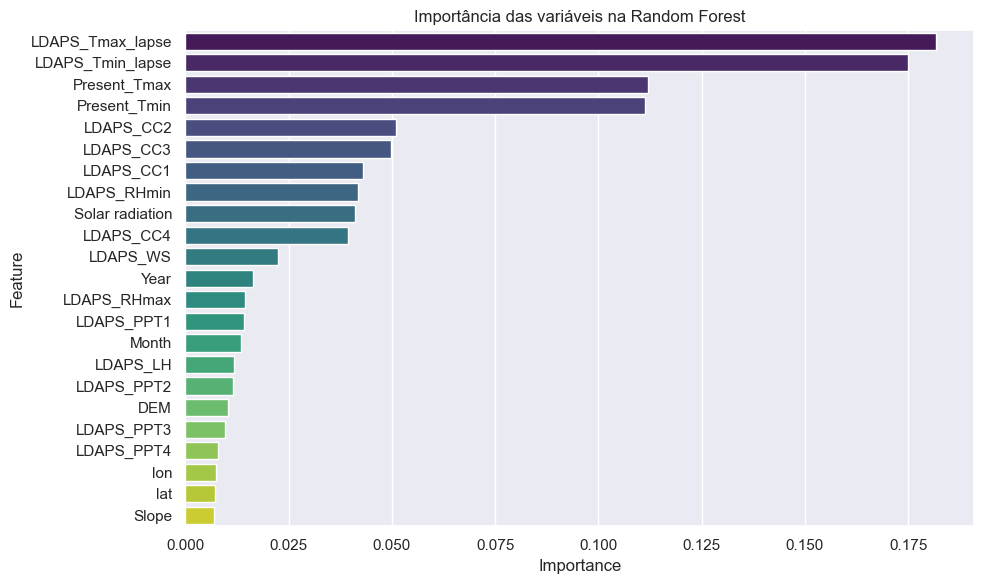

In [100]:
# Corrigir x_train para ser um DataFrame com os nomes das colunas originais
x_train_df = pd.DataFrame(x_train, columns=x.columns)

# Obter a importância das variáveis
importances = best_rf.feature_importances_
features = x_train_df.columns

# Criar DataFrame de importâncias
df_importance = pd.DataFrame({"Feature": features, "Importance": importances})
df_importance = df_importance.sort_values(by="Importance", ascending=False)

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importance, x="Importance", y="Feature", palette="viridis")
plt.title("Importância das variáveis na Random Forest")
plt.tight_layout()
plt.show()


### Avaliação do ganho do modelo depois de tunado


In [101]:
# Reconstrói o modelo RandomForestRegressor utilizando os melhores hiperparâmetros encontrados (best_params_)
# Embora o ajuste fino dos parâmetros tenha sido feito, observa-se que a acurácia do modelo permaneceu praticamente a mesma (~98,32%)
# Isso indica que o modelo já estava muito bem ajustado inicialmente e o ganho com o tuning foi marginal
mod_final.score(x_train,y_train)

0.9853038571220123

# Salvando o Modelo (usando joblib)



In [102]:
# 💾 Salvando o modelo treinado usando a biblioteca joblib
# A serialização do modelo permite reutilizá-lo posteriormente para previsões sem necessidade de re-treinamento
# Ideal para deploy ou uso em produção
import joblib

joblib.dump(mod_final,"Korea_Temperature_Prediction.pkl")

['Korea_Temperature_Prediction.pkl']

## Carregado o modelo salvo

In [103]:
model = joblib.load("Korea_Temperature_Prediction.pkl")

prediction = model.predict(x_test)

prediction=pd.DataFrame(prediction)
prediction

0       1
0     28.876  20.805
1     34.610  26.307
2     32.439  21.694
3     30.718  21.345
4     27.439  19.700
...      ...     ...
2067  33.598  26.693
2068  32.936  22.847
2069  33.185  25.759
2070  27.060  17.955
2071  30.145  23.578

[2072 rows x 2 columns]

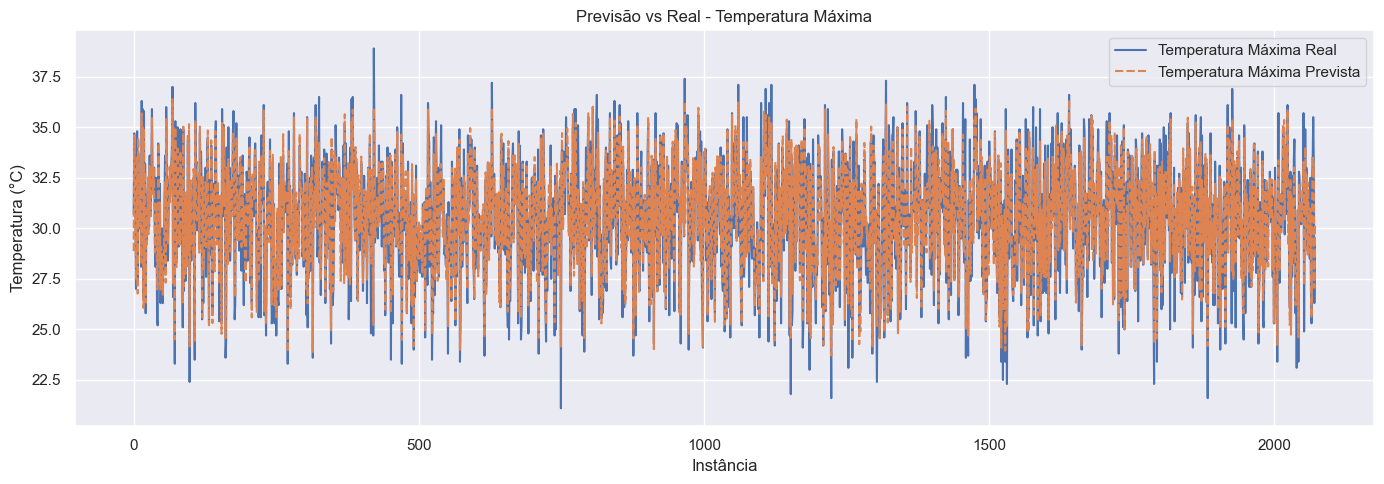

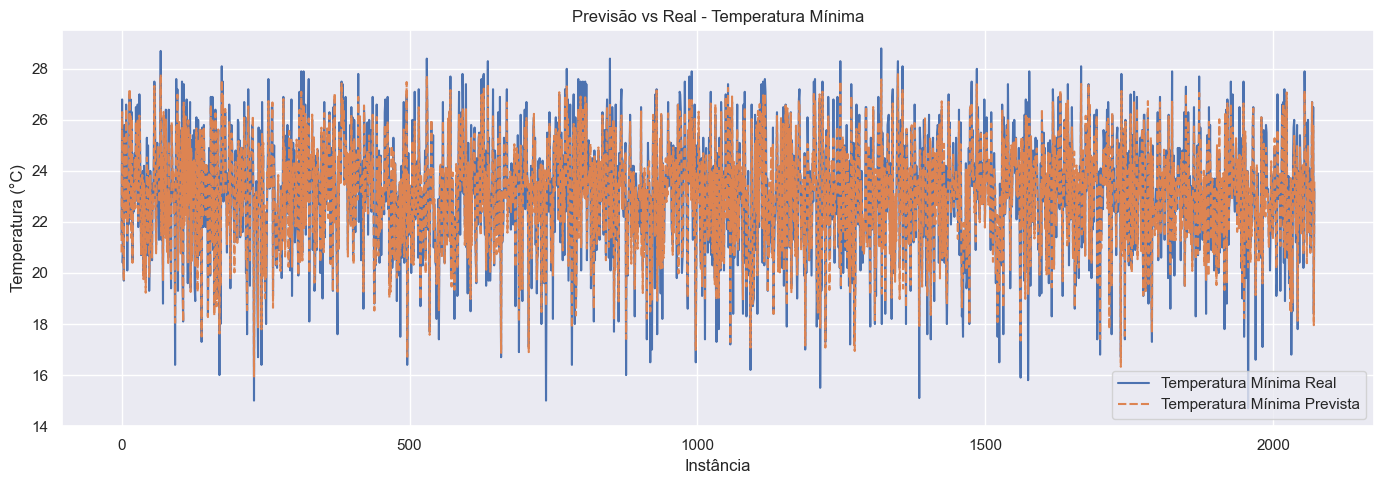

In [104]:
# Analisando o modelo com os dados de teste
# Construção de um DataFrame contendo os valores reais e previstos de temperatura
# As colunas são extraídas das previsões geradas pelo modelo e dos dados reais de teste
df_resultado = pd.DataFrame({
    "Temperatura Máxima Real": y_test.iloc[:, 0].values,
    "Temperatura Máxima Prevista": prediction.iloc[:, 0],
    "Temperatura Mínima Real": y_test.iloc[:, 1].values,
    "Temperatura Mínima Prevista": prediction.iloc[:, 1]
})

# 📈 Gráfico comparativo para Temperatura Máxima
# Visualiza lado a lado a série de valores reais e os valores previstos pelo modelo
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_resultado[["Temperatura Máxima Real", "Temperatura Máxima Prevista"]])
plt.title("Previsão vs Real - Temperatura Máxima")
plt.xlabel("Instância")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Gráfico comparativo para Temperatura Mínima
# Semelhante ao gráfico anterior, mas para a temperatura mínima
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_resultado[["Temperatura Mínima Real", "Temperatura Mínima Prevista"]])
plt.title("Previsão vs Real - Temperatura Mínima")
plt.xlabel("Instância")
plt.ylabel("Temperatura (°C)")
plt.grid(True)




plt.tight_layout()
plt.show()
